# Generative modelling in deep learning

Generative modelling in machine learning can aim at achieving different goals.

The first, obvious one is that a generative model can be used to generate more data, to be used afterwards by another algorithm. While a generative model cannot create more information to solve the issue of having too small datasets, it could be used to solve anonymity questions. Typically, sharing a generative model trained on private data could allow the exploitation of the statistical property of this data without sharing the data itself (which can be protected by privacy matters for example).

Another goal is to use generative modelling to better understand the data at hand. This is based on the hypothesis that a model that successfully learned to generate (and generalize) a dataset should have internally learned some efficient and compressed representation of the information contained in the data. In this case, analysing a posteriori the learned representation may give us insights on the data itself.

The notion of a generative model however needs to be more formally specified, in order to work with. What does it mean for the model to generate data that "looks like" the original dataset? A mathematical formulation of that is necessary, in order to define a training objective that can be used efficiently. Having some expert rate the quality of all generated datapoints one by one is definitely not an option.

Thus, modelling our data and models as probability distributions comes to the rescue. If we consider our data as coming from some underlying probability distribution, that we will name $p_D$, our goal is thus to train our model to represent another probability distribution, which we will name $p_\theta$, that should be some good approximation of $p_D$. Given that we only know $p_D$ through some set of realisations from it (the dataset), we can never hope to learn it exactly.

**Q1: Can you name some metrics that can be used to compare two given distributions $p_D$ and $p_\theta$?**

> The KL divergence is probably the most well known metric to compare distributions. Other simpler metrics can be the difference of mean values or the MSE of sampled data from each distribution but are less relevant in this case.

Most comparison methods can be separated into two kinds: those that compare the density of the distributions ($p_\theta(x)$ vs $p_D(x)$), and those that compare the values sampled from them. These two kinds of approaches have different behavior and trade-offs.

**Q2: Given we want to use them as an optimisation objective, what are the caveats to keep in mind about these two kinds?**

> * For those which compare the distributions, they can be quite computationaly expensive especially if we need to compute the derivate of an integral (cf KL) but they should give a better result in the end.
> * The other kind is a lot simpler to compute but gradients can be very noisy especially if the number of samples is low (increasing the number of samples means increasing the computational time).

In this work, we will focus on two of the most widely used generative models based on deep neural networks: Generative Adversarial Networks (GANs) and Variational AutoEncoders (VAEs), in order to compare them and understand their strengths and weaknesses.

### Generative Adversarial Networks

GANs structure is based on modelling the distribution $p_\theta$ as a learned deterministic function applied to a standard noise. Sampling from it is thus done as follows: first, some noise is sampled from a standard N-dimensional Gaussian distribution: $\epsilon \sim \mathcal{N}(0;I)$, and then the output is computed as a deterministic function $x = f_\theta(\epsilon)$. The function $f_\theta$ is implemented as a neural network, $\theta$ representing its learned parameters.

**Q3: What is, a priori, the impact of the choice of N, the dimension of the input noise $\epsilon$?**

> If N is large the network will be more expressive as the number of outputs of the network is defined by the input space (because the generative process is deterministic).

By construction, this generator structure only allows sampling the distribution $p_\theta$, and does not allow the computation of the density $p_\theta(x)$ (at least not without strong assumptions on $f_\theta$). Such a model thus needs a comparison method based on samples to be trained.

The smart idea of GANs is to instead use another neural network to model the objective. Another neural network is introduced: a classifier (that we call the discriminator) which is trained to distinguish examples from the dataset from examples generated by $p_\theta$. The reasoning is as follows:

The discriminator $D$ is trained using a classic classifier loss between the two classes defined as the samples generated by either $p_D$ or $p_\theta$. This way $D(x)$ can be interpreted as the probability that $x$ came from the real dataset:

$$ \mathcal{L}_D = \mathbb{E}_{p_D} \left[ -\log D(x) \right] + \mathbb{E}_{p_\theta} \left[ -\log \left(1-D(x)\right) \right] $$

From that, it can be shown that for the generator fixed, the optimal discriminator is given by $D(x) = \frac{p_D(x)}{p_\theta(x) + p_D(x)}$, and when reached its loss takes a specific value:

$$ \mathcal{L}_D = 2 \left( \log 2 - JSD(p_\theta \| p_D) \right) $$
, where JSD is the JS divergence used to measure the similarity of two distributions.
$$JSD(p_\theta \| p_D) = \frac{1}{2} \mathbb{E}_{p_D} \left[ log(\frac{2p_D}{p_D+p_\theta}) \right] + \frac{1}{2} \mathbb{E}_{p_\theta} \left[ log(\frac{2p_\theta}{p_D+p_\theta}) \right]$$
So, training the generator network to *maximize* the same loss would, assuming the discriminator is always trained to optimality, minimize the Jensen-Shannon Divergence between $p_\theta$ and $p_D$, and thus bring $p_\theta$ closer to $p_D$.

**Q4: Can you anticipate a caveat of using the JSD as a training objective for the generator?**

In the case when the distributions $p_{\theta}$ and $p_D$ are disjoint, the loss  $\mathcal{L}_D$ falls to zero, as well as the computed gradients. This causes the problem of vanishing gradients with very small updates at each iteration.

Having the generator trained to maximize $\mathcal{L}_D$ is equivalent to setting its training loss to $ \mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x)) $.

**Q5: This loss only gives feedback to the generator on samples it generated, what problem may this cause?**

During training, $p_{\theta}$ changes so that the discriminator fails to make good predictions. Training exclusively on generated samples makes the process very unstable since the discriminator continuously changes direction in order to fit the generated data.

We will now work on implementing a GAN on a simple toy problem, to get a feeling of its behavior and test our theoretical insights. For this we will use the `pytorch` library.

While a real problem would be generating images for example (each datapoint $x$ would then be a different image), this is a kind of task that easily requires intensive CPU/GPU power, and image datasets are difficult to visualize from a geometric point of view (even small images contains hundreds of pixels, and nobody can visualize points in a 100-dimensional space). So instead we will focus on points in the plane: each datapoint $x$ will actually be a couple of numbers $(x1, x2)$, and our target dataset will be a 2D two-moons shape with some noise.

In [1]:
import torch
import math
from sklearn import datasets
import numpy as np

# Our dataset is mathematically defined, we can generate batches on the fly and enjoy
# an infinite-size dataset
def generate_batch(batchlen):
    """This function generates a batch of length 'batchlen' from the dataset
    """
    data = datasets.make_moons(n_samples=batchlen, noise=0.05)[0].astype(np.float32)
    return torch.from_numpy(data)

Let's plot a large batch, to see what the dataset looks like.

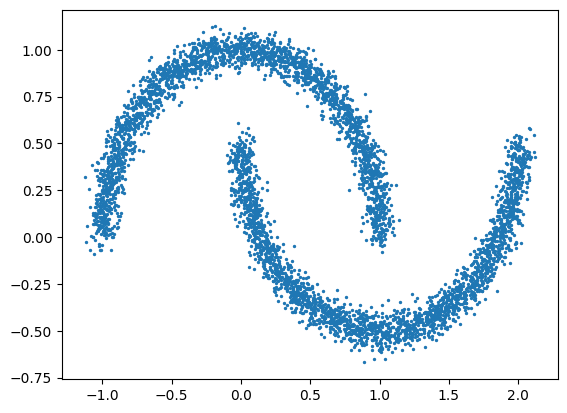

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

batch = generate_batch(5000)


plt.scatter(batch[:,0], batch[:,1], s=2.0)
plt.show()

We now need to define our two neural networks, the generator and the discriminator. The generator will take as input a value $z$ sampled from a Gaussian prior, and output a value $x$ (thus a couple $(x_1,x_2)$). The discriminator takes as input a value $x$, and is a binary classifier.

In [3]:
import torch.nn as nn
import torch.nn.functional as F

# Choose a value for the prior dimension
PRIOR_N = 2

# Define the generator
class Generator(nn.Module):
    def __init__(self,depth,width,activation=nn.Tanh):
        super().__init__()
        l = [nn.Linear(PRIOR_N, width),activation()]
        for i in range(depth-2):
            l.append(nn.Linear(width,width))
            l.append(activation())
        l.append(nn.Linear(width, 2))
        self.net = nn.Sequential(*l)

    def __call__(self, z):
        return self.net(z)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0).cuda()
        return self.__call__(z)


# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self,depth,width,activation=nn.Tanh):
        super().__init__()
        l = [nn.Linear(PRIOR_N, width),activation()]
        for i in range(depth-2):
            l.append(nn.Linear(width,width))
            l.append(activation())
        l.append(nn.Linear(width, 2))
        l.append(nn.Sigmoid())
        self.net = nn.Sequential(*l)

    def __call__(self, x):
        return self.net(x)

With these classes in shape, now is only needed the training loop. To stick with the mathematical GAN framework, we should train the discriminator until convergence between each training step of the generator. This is not practical for two reasons: first it takes a lot of time, and second if the discriminator is too good, it will generate vanishing gradients to the generator (as seen in **Q4**).

We will thus train the discriminator a fixed number of times between each training iteration of the generator.

step 0: discriminator: 1.483e+00, generator: -8.245e-01


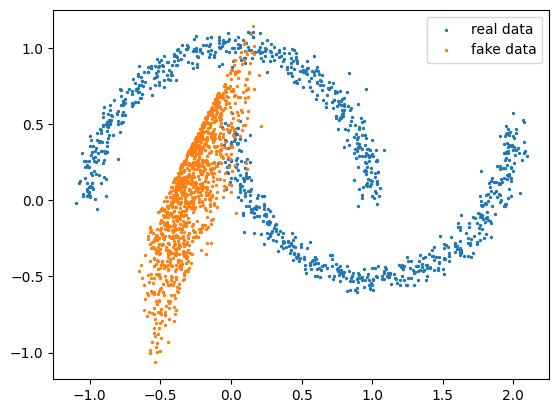

step 1000: discriminator: 1.394e+00, generator: -6.965e-01


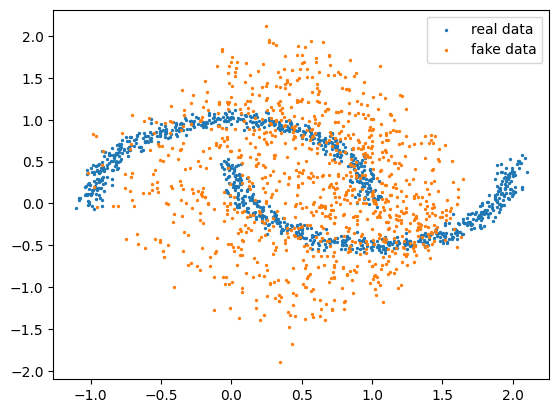

step 2000: discriminator: 1.385e+00, generator: -6.945e-01


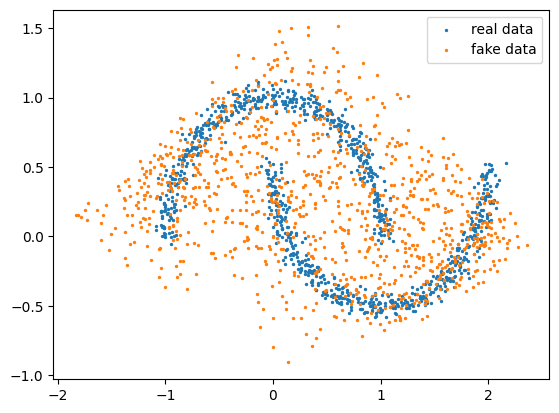

step 3000: discriminator: 1.387e+00, generator: -6.931e-01


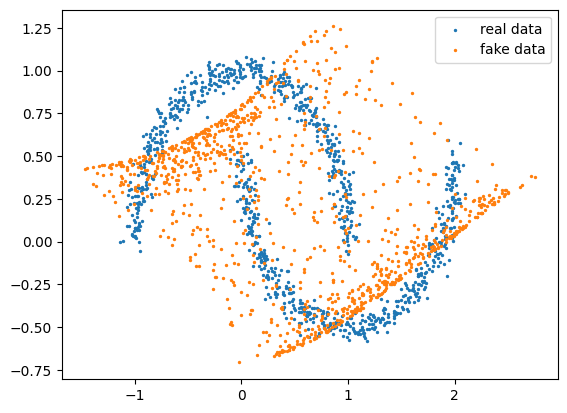

step 4000: discriminator: 1.387e+00, generator: -6.948e-01


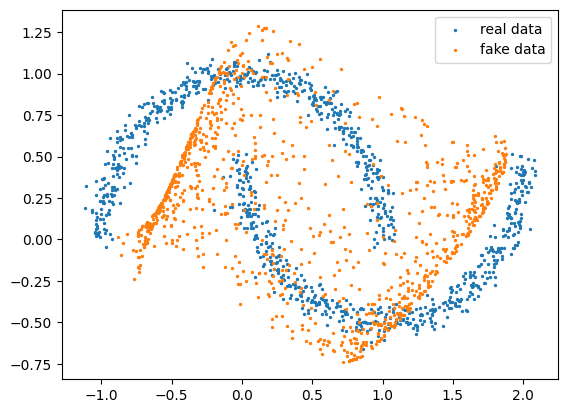

step 5000: discriminator: 1.385e+00, generator: -6.927e-01


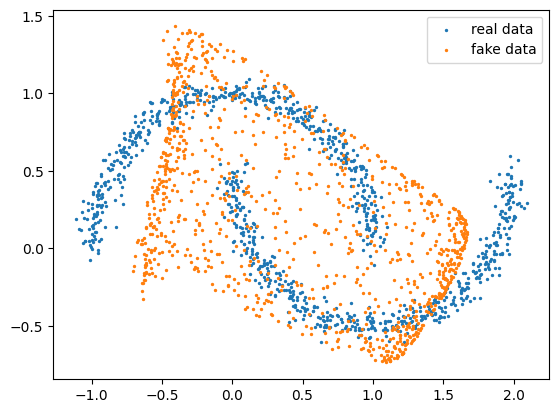

step 6000: discriminator: 1.384e+00, generator: -7.019e-01


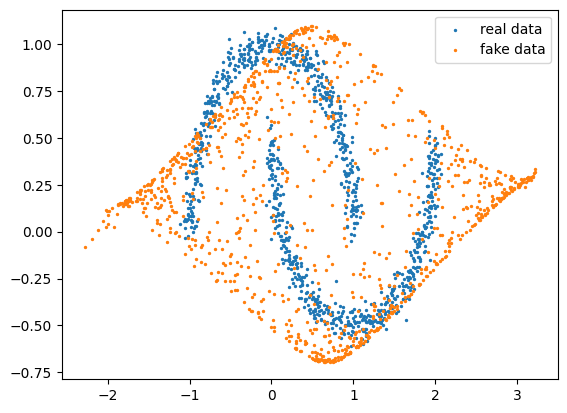

step 7000: discriminator: 1.384e+00, generator: -6.940e-01


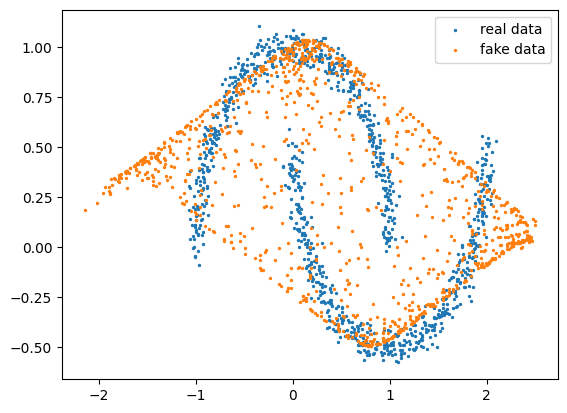

step 8000: discriminator: 1.387e+00, generator: -6.942e-01


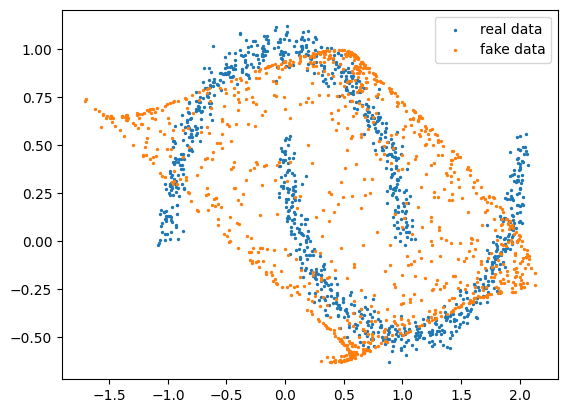

step 9000: discriminator: 1.384e+00, generator: -6.960e-01


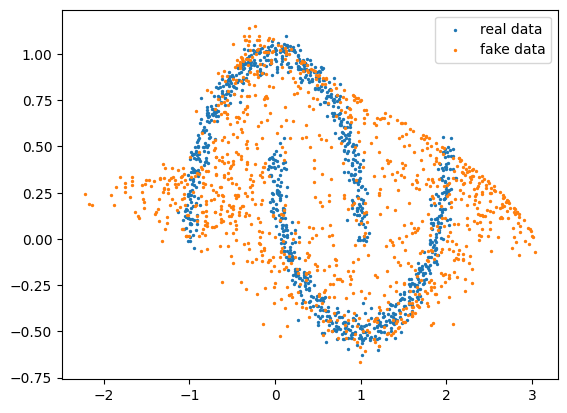

step 10000: discriminator: 1.387e+00, generator: -6.909e-01


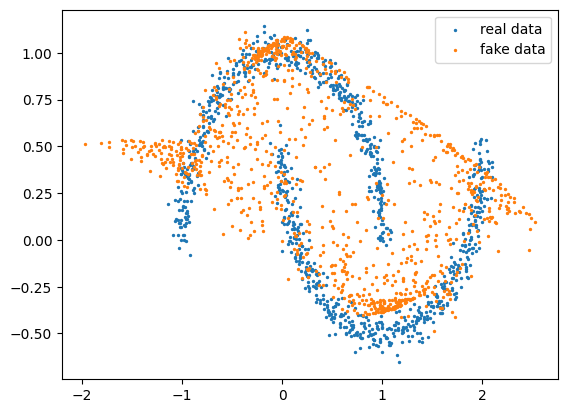

step 11000: discriminator: 1.386e+00, generator: -6.927e-01


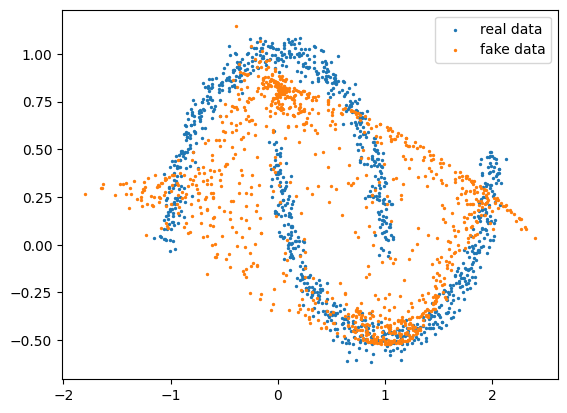

step 12000: discriminator: 1.385e+00, generator: -6.938e-01


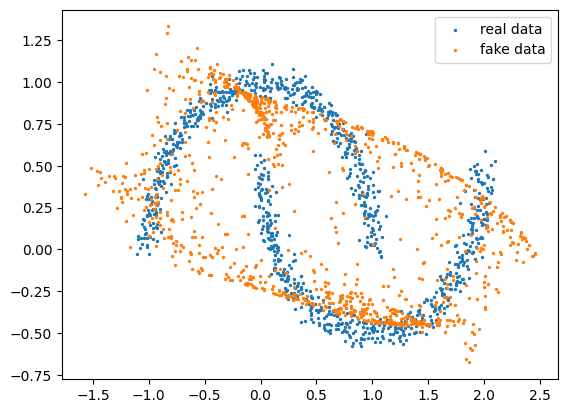

step 13000: discriminator: 1.387e+00, generator: -6.947e-01


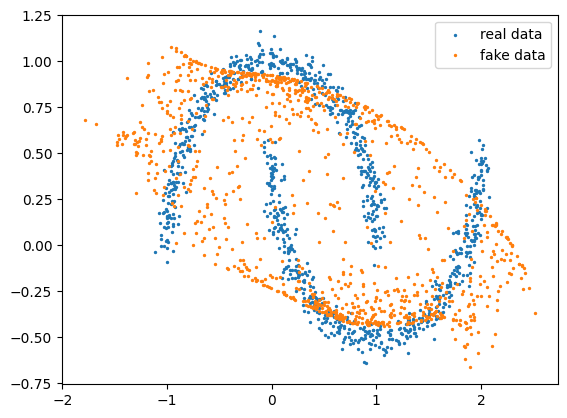

step 14000: discriminator: 1.386e+00, generator: -6.932e-01


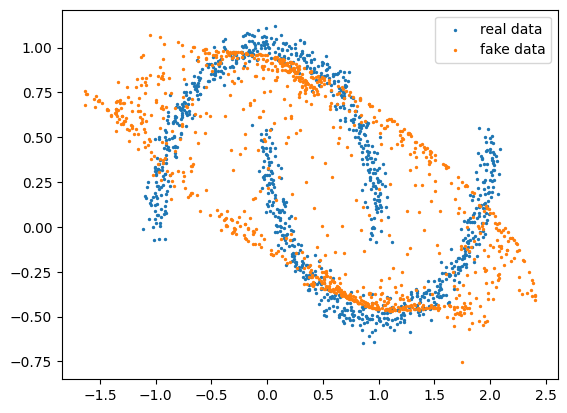

step 15000: discriminator: 1.387e+00, generator: -6.923e-01


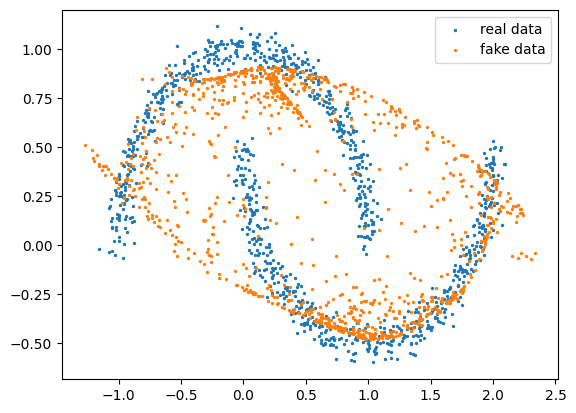

step 16000: discriminator: 1.387e+00, generator: -6.933e-01


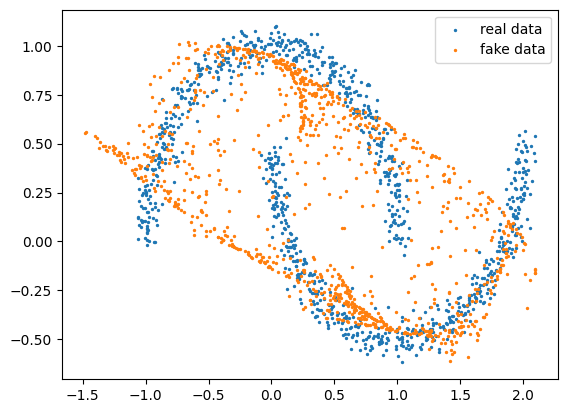

step 17000: discriminator: 1.385e+00, generator: -6.939e-01


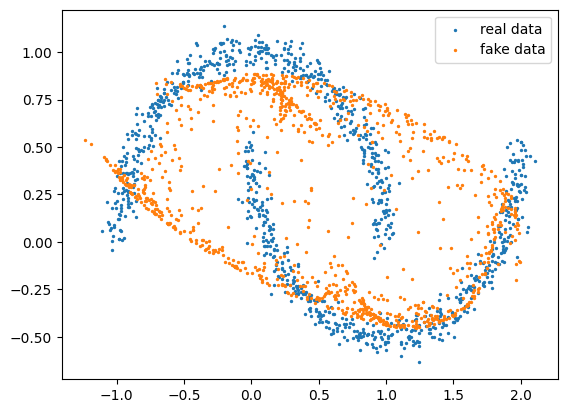

step 18000: discriminator: 1.385e+00, generator: -6.936e-01


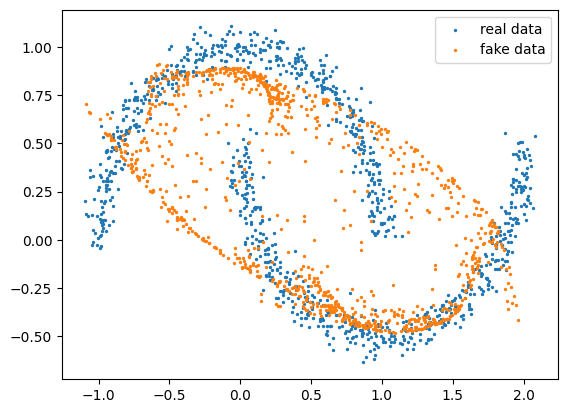

step 19000: discriminator: 1.387e+00, generator: -6.932e-01


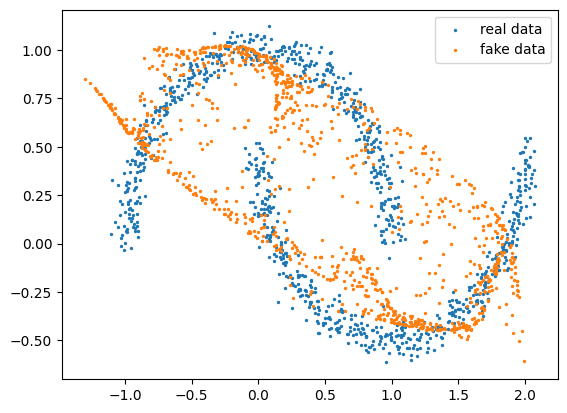

step 20000: discriminator: 1.388e+00, generator: -6.900e-01


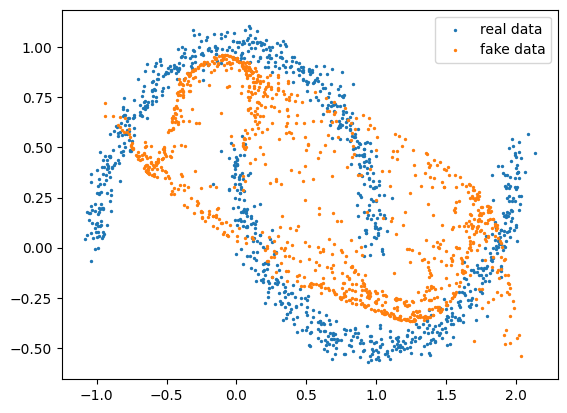

(tensor(1.3883, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(-0.6900, device='cuda:0', grad_fn=<MeanBackward0>))

In [4]:
# Number of times to train the discriminator between two generator steps
TRAIN_RATIO = 1
# Total number of training iterations for the generator
N_ITER = 20001
# Batch size to use
BATCHLEN = 128

generator = Generator(2,16)

discriminator = Discriminator(2,16)

def train(generator,discriminator,n_iter,train_ratio,only_plot_last=False,show=False):
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    for i in range(n_iter):
        optim_gen = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5,0.9))
        optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5,0.9))
        # train the discriminator
        for _ in range(train_ratio):
            discriminator.zero_grad()
            real_batch = generate_batch(BATCHLEN).cuda()
            fake_batch = generator.generate(BATCHLEN)
            #
            # == COMPUTE THE DISCRIMINATOR LOSS HERE ==
            real_disc = discriminator(real_batch)
            fake_disc = discriminator(fake_batch)
            disc_loss = (-torch.log(real_disc)).mean() + (-torch.log(1-fake_disc)).mean()
            #
            disc_loss.backward()
            optim_disc.step()
        # train the generator
        generator.zero_grad()
        fake_batch = generator.generate(BATCHLEN)
        #
        # == COMPUTE THE GENERATOR LOSS HERE
        fake_disc = discriminator(fake_batch)
        gen_loss = (torch.log(1-fake_disc)).mean()
        #
        gen_loss.backward()
        optim_gen.step()
        if i%1000 == 0 and not only_plot_last or only_plot_last and i == n_iter-1:
            # plot the result
            real_batch = generate_batch(1024)
            fake_batch = generator.generate(1024).detach().cpu()
            plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
            plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
            plt.legend()
            if not only_plot_last:
                print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
                plt.show()
    return disc_loss,gen_loss
train(generator,discriminator,N_ITER,TRAIN_RATIO)

Complete the previous code and train your model.

Depending on your choice of parameters, the training may not go well at all, with the generator completely collapsing quickly at the beginning of the training. It has been observed by the litterature that the generator's loss $\mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x))$ is often to blame.

**Q6: Why could we anticipate that this loss could cause this?**

> If the discriminator is very good, for $x \sim p_\theta$ then $1-D(x)$ will be a flat 0 with a low gradient meaning the gradient of the loss will be very low (vanishing gradient).

This issue is solved by replacing the generator loss by an alternative loss: $\mathcal{L}_G = \mathbb{E}_{p_\theta} [ -\log D(x) ]$ to avoid gradient vanishing.

**Q7: Inspect the impact of these different factors:**

- depth / width of the generator network
- depth / width of the discriminator network
- impact of `TRAIN_RATIO`

In [5]:
#Parameters definition
default_gen_width = 16
default_gen_depth = 2
default_dis_width = 16
default_dis_depth = 2
default_train_ratio = 1

width_values = [8,16,32]
depth_values = [2,3,4]
train_ratio_values = [1,5,10]

plot_size = 15

<ipython-input-6-e20a550aa424>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,len(width_values),i+1)


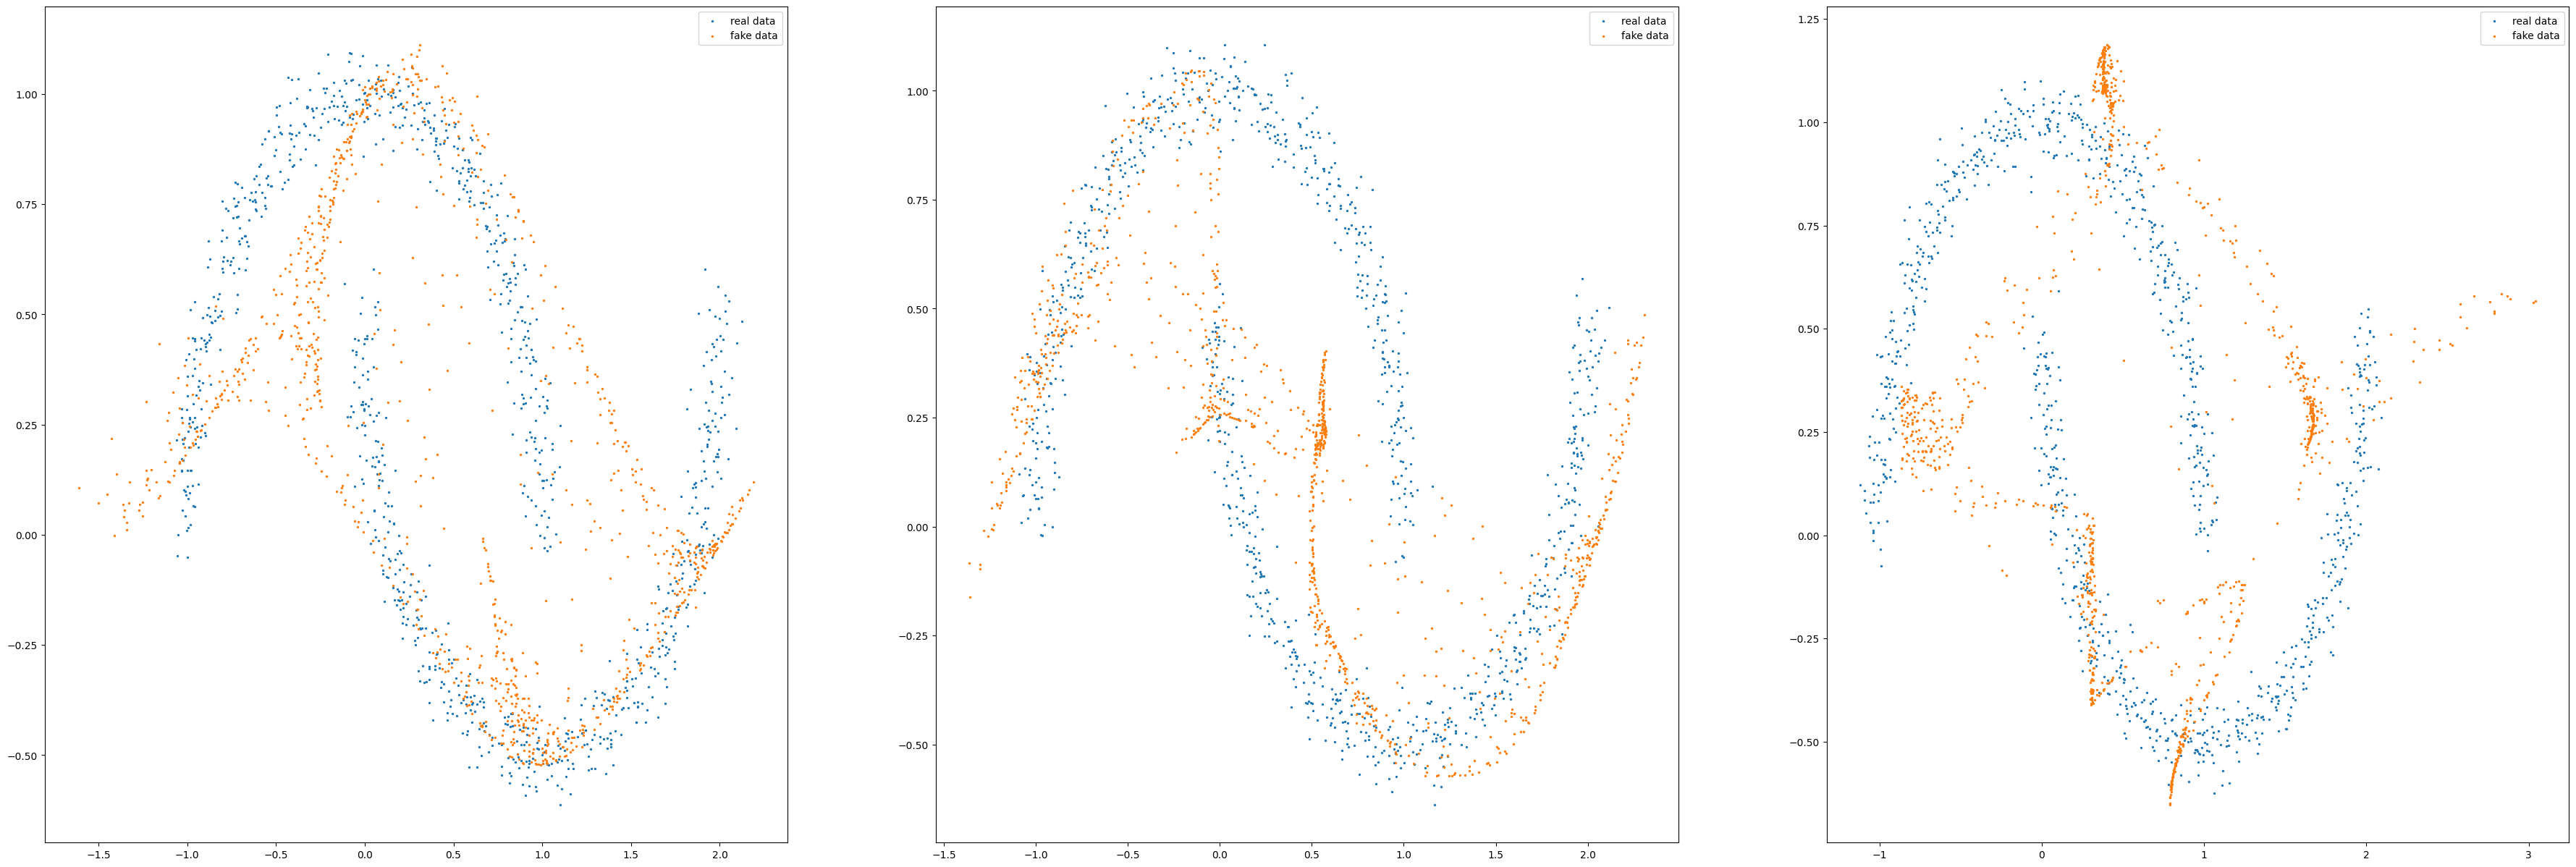

In [6]:
#Width/Depth generator
fig,ax = plt.subplots(figsize=(plot_size*len(width_values),plot_size))
for i,(width,depth) in enumerate(zip(width_values,depth_values)):
    plt.subplot(1,len(width_values),i+1)
    generator = Generator(depth,width)
    discriminator = Discriminator(default_dis_depth, default_dis_width)
    train(generator,discriminator,N_ITER,default_train_ratio,only_plot_last=True)
plt.show()

> Here the size of the generator doesn't seem to change very much. Even with a large generator the result doesn't really improve.

<ipython-input-7-f9bb05309203>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,len(width_values),i+1)


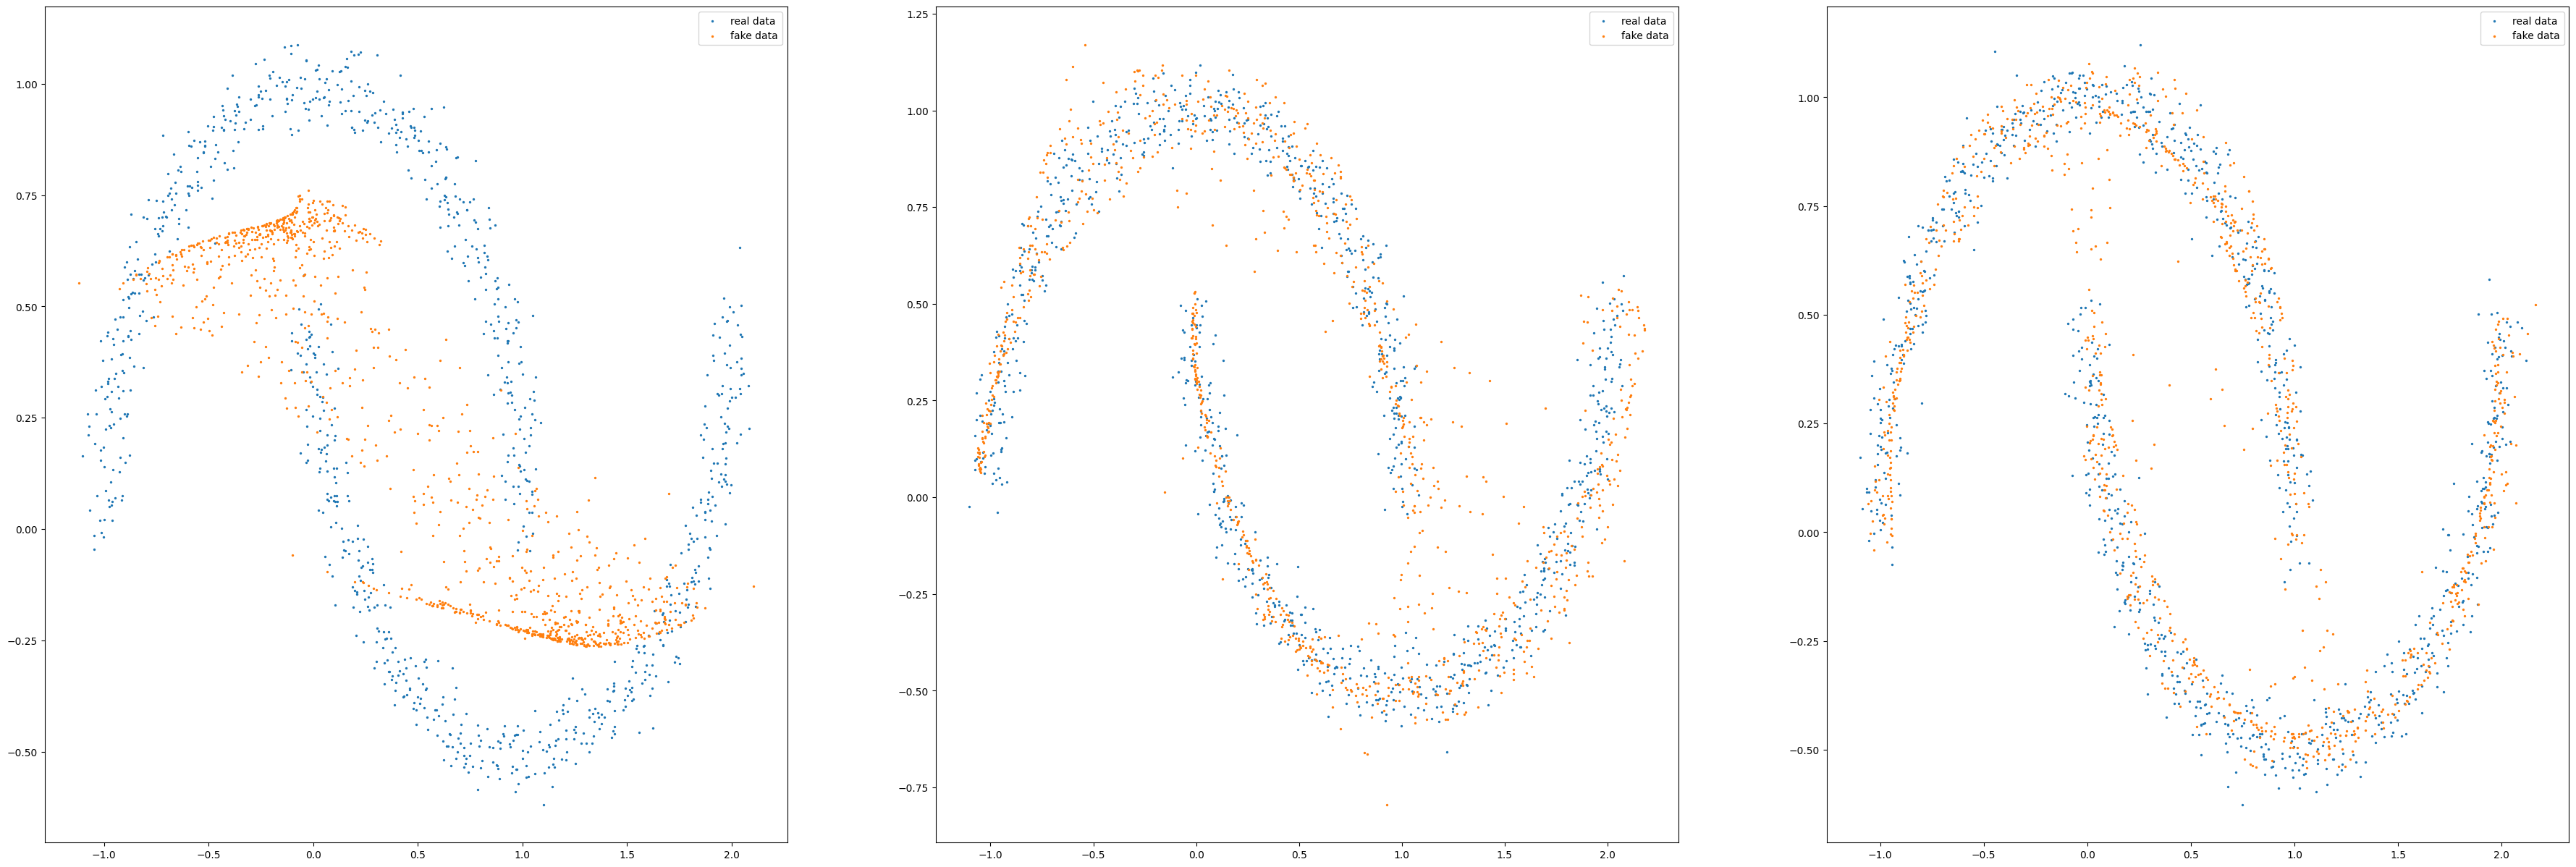

In [7]:
#Width/Depth discriminator
fig,ax = plt.subplots(figsize=(plot_size*len(width_values),plot_size))
for i,(width,depth) in enumerate(zip(width_values,depth_values)):
    plt.subplot(1,len(width_values),i+1)
    generator = Generator(default_dis_depth, default_dis_width)
    discriminator = Discriminator(depth,width)
    train(generator,discriminator,N_ITER,default_train_ratio,only_plot_last=True)
plt.show()

> However by changing the size of the discriminator we observe a much better fit of the distribution.

<ipython-input-8-c8b95083ff96>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,len(width_values),i+1)


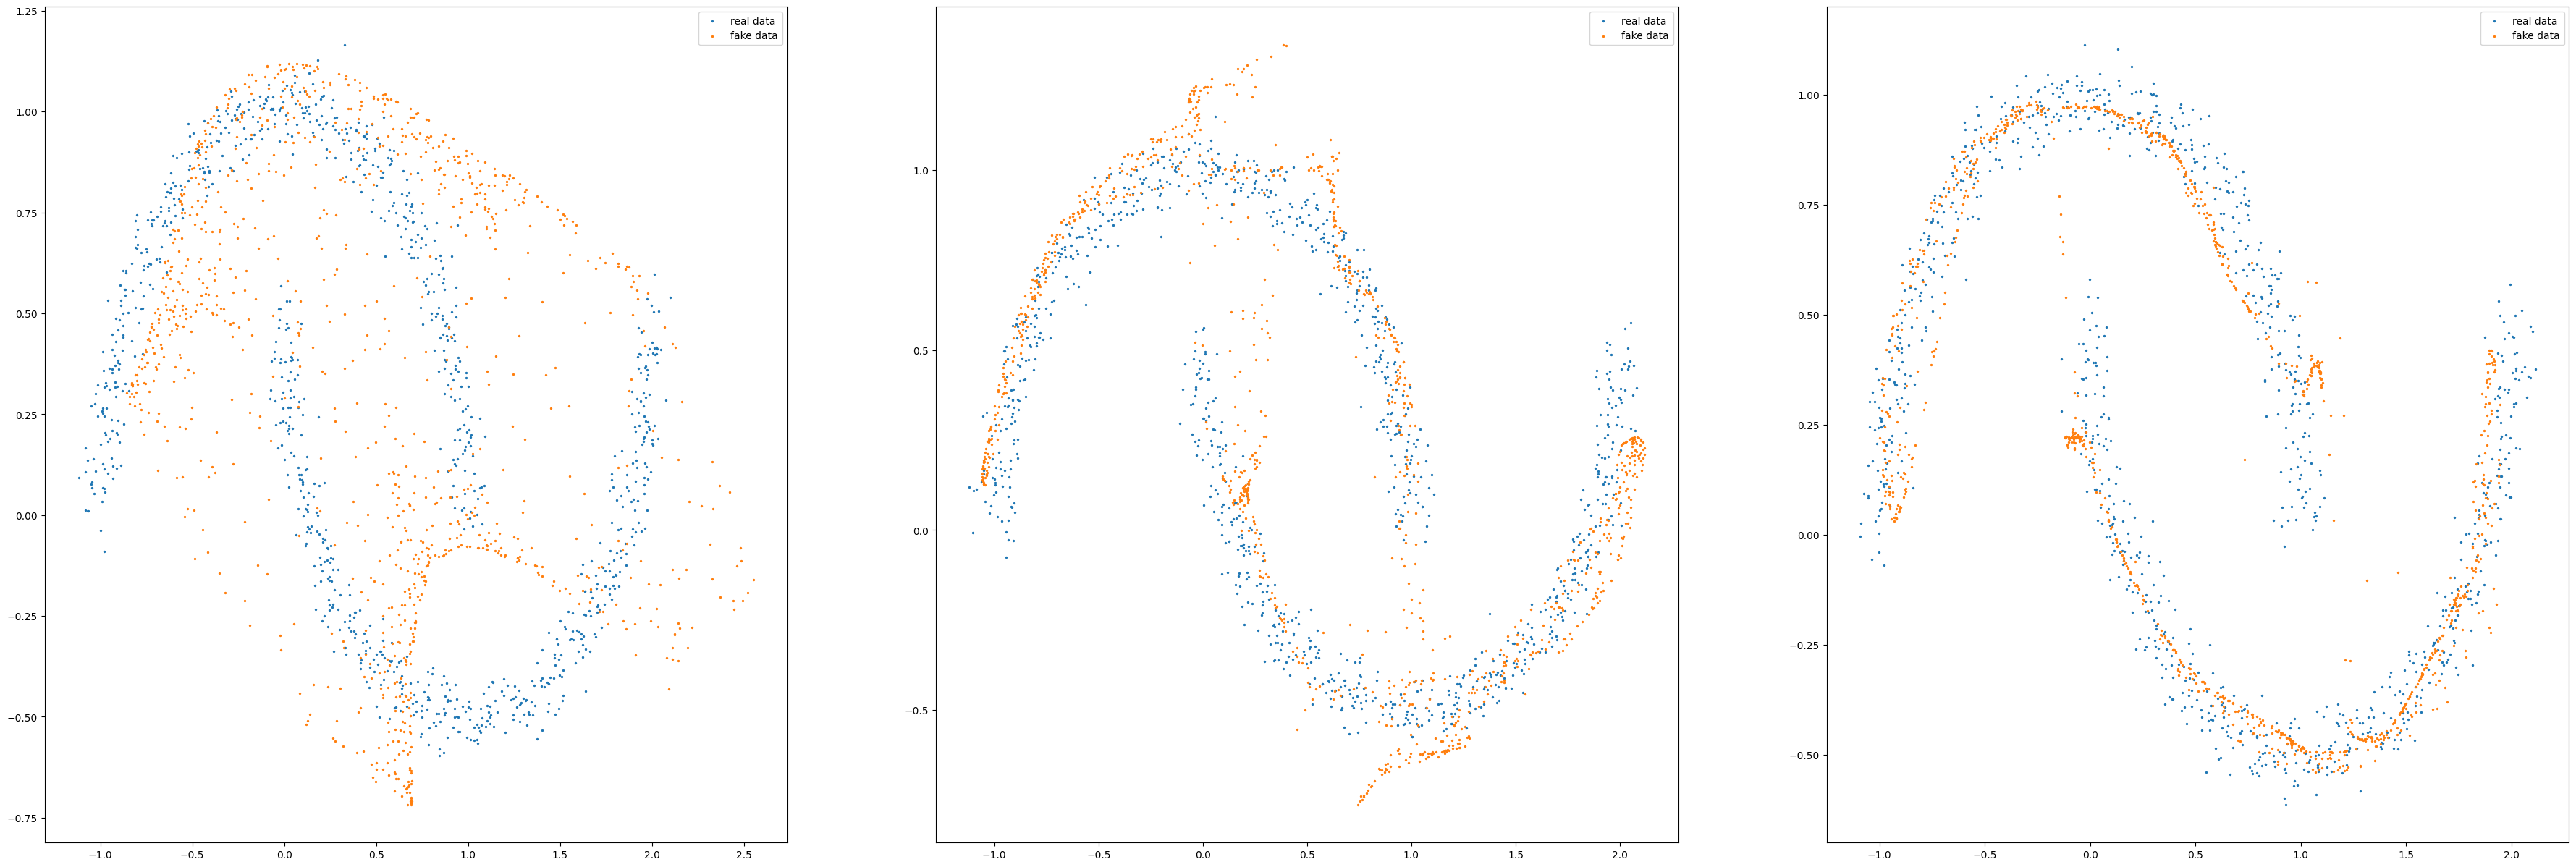

In [8]:
#Width/Depth generator & discriminator
fig,ax = plt.subplots(figsize=(plot_size*len(width_values),plot_size))
for i,(width,depth) in enumerate(zip(width_values,depth_values)):
    plt.subplot(1,len(width_values),i+1)
    generator = Generator(depth,width)
    discriminator = Discriminator(depth,width)
    train(generator,discriminator,N_ITER,default_train_ratio,only_plot_last=True)
plt.show()

> Same result by improving the size of both.

<ipython-input-9-cbd3cea36b4c>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,len(width_values),i+1)


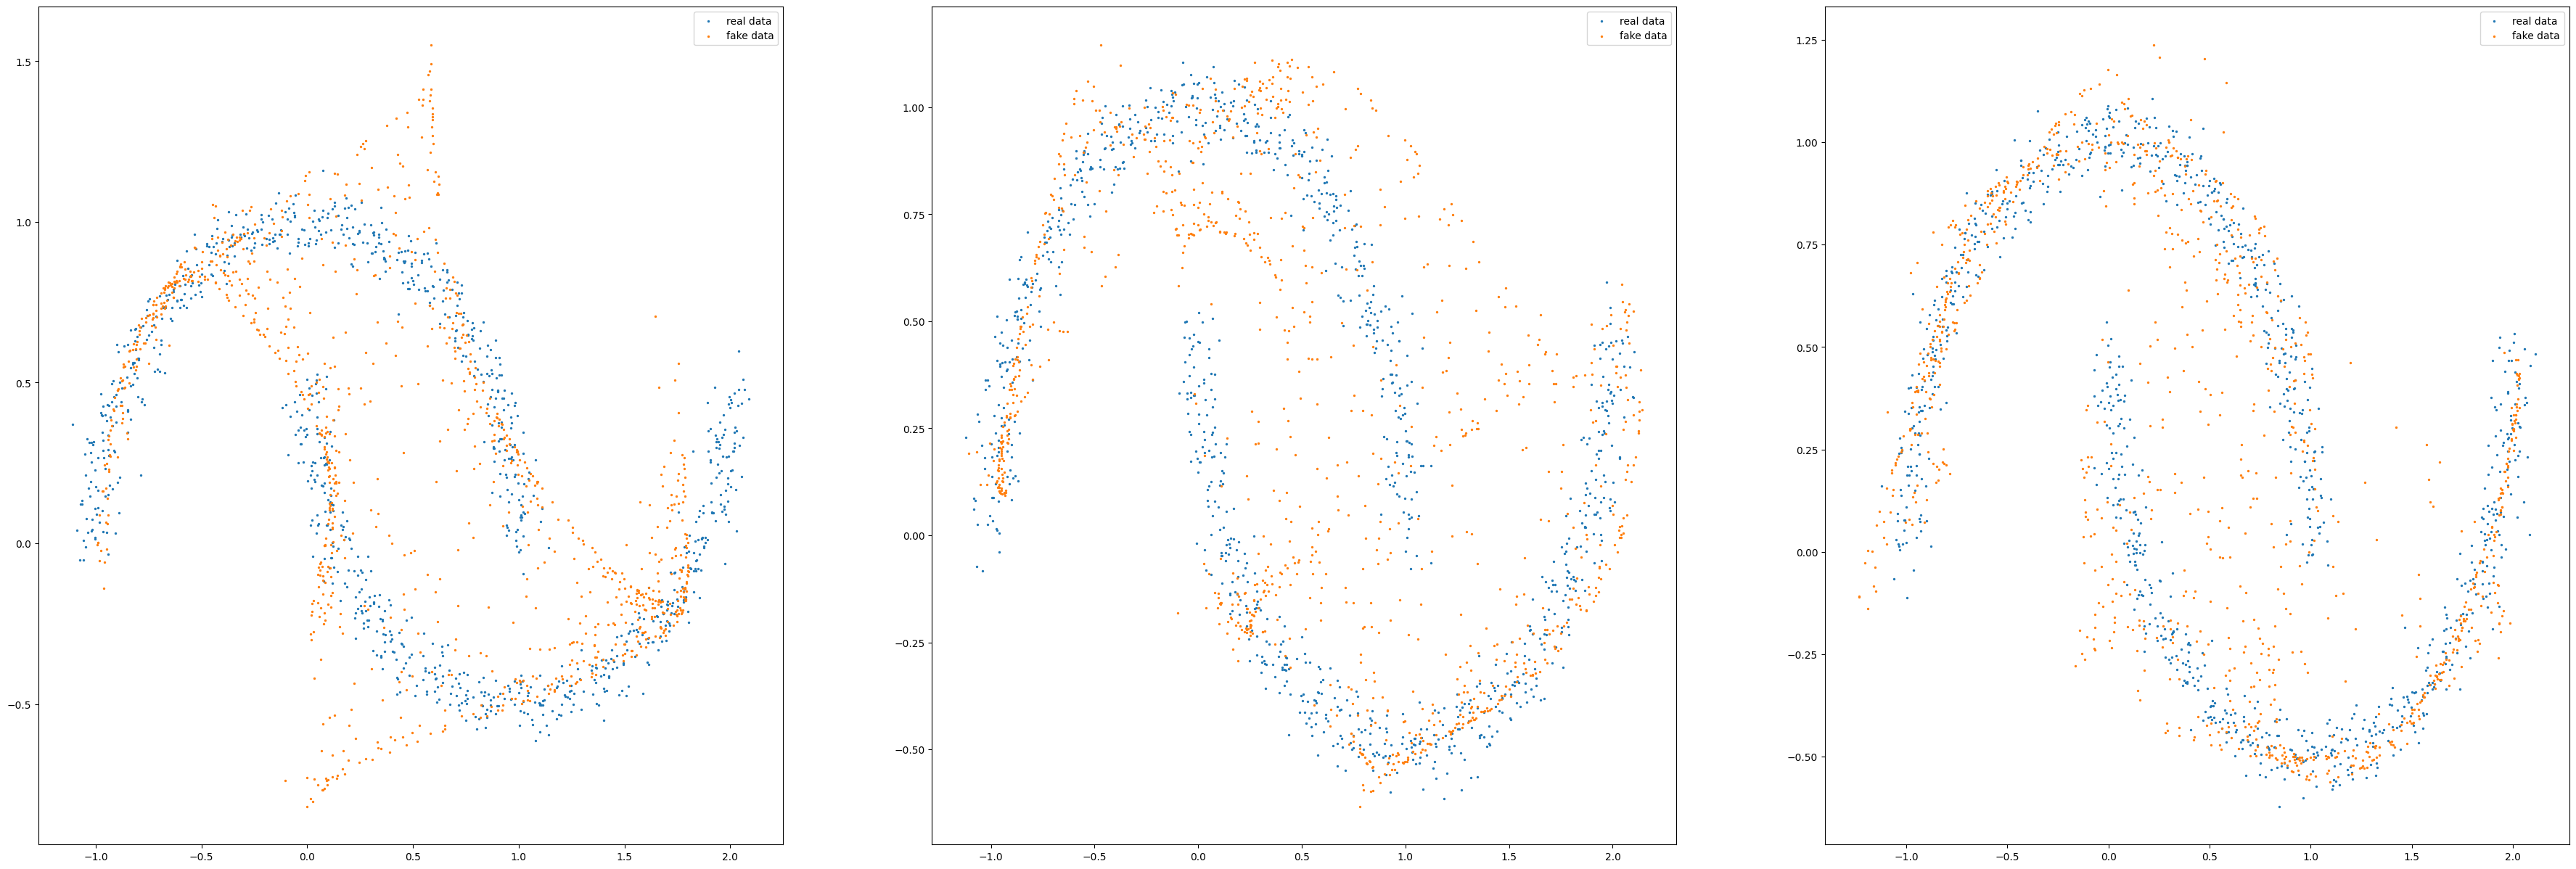

In [9]:
#Train ratio
fig,ax = plt.subplots(figsize=(plot_size*len(width_values),plot_size))
for i,train_ratio in enumerate(train_ratio_values):
    plt.subplot(1,len(width_values),i+1)
    generator = Generator(default_dis_depth, default_dis_width)
    discriminator = Discriminator(default_dis_depth, default_dis_width)
    train(generator,discriminator,N_ITER,train_ratio,only_plot_last=True)
plt.show()

> On the other hand even with a small generator and discriminator having a bigger train ratio fixes the problem.

> In the end, as long as the generator has the expressiveness to understand the distribution, the problem comes from the discriminator. It is therefore important to train the discriminator well for the generator to learn accurately. Thus training the discriminator more (increase the train ratio) makes it possible to solve the issue. Another possibility is to take a bigger discriminator so that it requires less epochs to learn.

For further readings on GANs, you can see the following papers:

- Generative Adversarial Networks *(Goodfellow et al.)*: [arXiv:1406.2661](https://arxiv.org/abs/1406.2661)
- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks *(Radford et al.)*: [arXiv:1511.06434](https://arxiv.org/abs/1511.06434)
- A Style-Based Generator Architecture for Generative Adversarial Networks *(Karras et al.)* [arxiv:1812.04948v3](https://arxiv.org/abs/1812.04948v3)

### Variational AutoEncoders

Another well-known approach to generative modelling is embodied by Variational AutoEncoders (VAEs). While the generative model itself and the procedure to sample it is similar to GANs, the way it is trained is not.

The main goal of VAEs is to optimize the likelihood of the real data according to the generative model. In other words, maximize $\mathbb{E}_{p_D} \left[\log p_\theta(x) \right ]$, which is equivalent to minimizing $D_{KL}(p_D \| p_\theta)$.
$$D_{KL}(p_D \| p_\theta) = \mathbb{E}_{p_D}\left[ log(\frac{p_D}{p_\theta}) \right]$$

**Q8: Prove this equivalence.**

$argmax_{θ}{\mathbb{E}_{p_D} \left[\log p_\theta(x) \right ]} = argmax_{θ}{\mathbb{E}_{p_D} \left[\log p_\theta(x) \right ] - \mathbb{E}_{p_D} \left[\log p_D(x) \right ]} = argmax_{θ}{\mathbb{E}_{p_D}\left[ log(\frac{p_D}{p_\theta}) \right]} = argmin_{θ}{\mathbb{E}_{p_D}\left[ log(\frac{p_\theta}{p_D}) \right]} $

However, the classes of distributions for which $\log p_\theta(x)$ can be analytically computed and optimized is very restricted, and not suitable for real world problems. The main idea of the VAE is thus to introduce a latent variable $z$ and decompose the distribution as: $p_\theta(x, z) = p_\theta(x | z) p(z)$. Here $p(z)$ is some fixed prior and $p_\theta(x | z)$ is a simple distribution whose parameters are the output of a neural network.

For example, you could have $p(z)$ be a standard $\mathcal{N}(0;1)$ and $p_\theta(x | z)$ be defined as a gaussian $\mathcal{N}(\mu_\theta(z); \sigma_\theta(z))$ where $\mu_\theta(z)$ and $\sigma_\theta(z)$ are created by the neural network you will train. In this case, the resulting distribution $p_\theta(x) = \int_z p_\theta(x|z)p(z)dz$ is an infinite mixture of Gaussians, which is a much more expressive class of distributions.

Now, this cannot stop here, as we are not able to analitically compute the density $p_\theta(x)$. The second main idea of the VAE is to introduce another, auxilliary distribution: $q_\phi(z | x)$, which will be modelled by a neural network similarly to $p_\theta(x | z)$. Introducing it allows us to create a lower bound for $\log p_\theta(x)$:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log p_\theta(x) \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Following Bayes theorem, $p_\theta(x) p_\theta(z|x) = p_\theta(x, z) = p_\theta(x|z) p(z)$, so we get:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log \frac{p_\theta(x|z) p(z)}{p_\theta(z|x)} \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Re-organizing the terms:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log \frac{q_\phi(z|x)}{p_\theta(z|x)} + \mathbb{E}_{z \sim q_\phi} \log \frac{p(z)}{q_\phi(z|x)} + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x | z)$$

This can be re-expressed like so:

$$\log p_\theta(x) = D_{KL}(q_\phi(z | x) \| p_\theta(z | x)) - D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x|z)$$

The 3 terms of this equality can be interpreted like so:

- the first term measures how much $q_\phi(z | x)$ is similar to $p_\theta(z | x)$, or in other words is a good inverse of $p_\theta(x | z)$
- the second term measures how similar $q_\phi(z|x)$ is from the latent prior $p(z)$
- the third term is linked to how likely $p_\theta$ is to yield the given $x$ when $z$ is sampled from $q_\phi(z | x)$ rather than $p(z)$

It is interesting to note that the first term, being a KL-divergence is always positive. As such the combination of the last two terms forms a lower bound of $\log p_\theta(x)$ which *can* be computed and used as a training objective. This bound is called the *Evidence Lower-Bound (ELBO)*. Simply flipping its sign can make it into a loss that can be minimized by gradient descent:

$$ \mathcal{L}_{ELBO} = D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} [ - \log p_\theta(x|z) ]$$

From this formulation comes the parallel with auto-encoders that give the VAE its name: $q_\phi(z | x)$ can be seen as a *probabilistic encoder* from the data $x$ to the latent space $z$, and $p_\theta(x | z)$ can be seen as a *probabilistic decoder* from the latent space $z$ to the data $x$. In this case the second term of $\mathcal{L}_{ELBO}$ is the loss measuring the reconstruction quality of the auto-encoder, and the first term can be seens as a regularization of the latent space.

![VAE](vae-gaussian.png)

**Q9: We can see that $p(z)$ is never sampled during the training process, how can that be a problem?**

During the training process, we are drawing $z$ using the posterior $P(z|x)$ because we are reconstructing a certain data point $x$. During the generation process, we are drawing $z$ from the prior $P(z)$ instead. The risk of sampling exclusively from $P(z|x)$ is to learn perfect reconstruction and overfit the data.

A typical choice to represent $q_\phi(z | x)$ is to use a diagonal Gaussian distribution $\mathcal{N}(\mu_\phi(x); Diag(\sigma_\phi^2(x)))$, which makes the KL-divergence term of $\mathcal{L}_{ELBO}$ analytically computable.

**Q10: Assuming $p(z)$ is a $\mathcal{N}(0; Id)$ gaussian, what is the value of $D_{KL}(q_\phi(z | x) \| p(z))$?**

\begin{equation}
D_{KL}(q_\phi(z | x) \| p(z)) = \frac{1}{2} \Big( log \frac{|I|}{|Diag(\sigma_\phi^2(x)))|} - n + tr( Diag(\sigma_\phi^2(x))) + \mu_\phi(x)^T \mu_\phi(x)  \Big)\\
= \frac{1}{2} \Big( - log \prod_i \sigma_{i}^2(x)  - n + \sum_i \sigma_i^2(x) + \sum_i \mu_i^2(x)  \Big) \\
= \frac{1}{2} \Big( - \sum_i (log({\sigma_{i}^2(x))} + 1) + \sum_i \sigma_i^2(x) + \sum_i \mu_i^2(x)  \Big)
\end{equation}


We will also model $p_\theta(x | z)$ as a diagonal Gaussian $\mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta^2(z)))$.


**Note:** For the following, be careful about the difference between $\mu_\phi, \sigma_\phi$ which define the Gaussian distribution of the *encoder* $q_\phi$ and $\mu_\theta, \sigma_\theta$ which define the Gaussian distribution of the *decoder* $p_\theta$.

**Q11: What is the expression of $-\log p_\theta(x | z)$ for given $x$ and $z$?**

\begin{equation}
-\log p_\theta(x | z) = - log \Big ( \frac{1}{(2\pi)^{n/2} |Diag(\sigma_\theta^2(z)|} \exp{-\frac{1}{2} (x - \mu_\theta(z))^T Diag(\sigma_\theta^2(z))^{-1} (x - \mu_\theta(z)) } \Big ) = \frac{1}{2} \sum_i log{\sigma_{i}^2(z)} + \frac{n}{2} log2\pi +\frac{1}{2} (x - \mu_\theta(z))^T Diag(\frac{1}{\sigma_\theta^2(z)})(x - \mu_\theta(z))
\end{equation}

We will build and train a VAE using the same dataset as previously, in order to compare its behavior to GANs. For numerical stability, we will interpret the output of the encoder and decoder networks as $(\mu, \log\sigma^2)$, rather than $(\mu, \sigma)$.

In [10]:
# Choose a value for the latent dimension
LATENT_N = 10
hidden_size = 16


# Define the generator
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(2, hidden_size * 2)
        self.hidden2 = nn.Linear(hidden_size * 2, hidden_size)

        self.fc_mu = nn.Linear(hidden_size, LATENT_N)
        self.fc_logvar = nn.Linear(hidden_size, LATENT_N)

    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian q_\phi(z | x)
    def __call__(self, x):
        x = torch.nn.functional.relu(self.hidden1(x))
        x = torch.nn.functional.relu(self.hidden2(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return (mu, logvar)


# Define the discriminator
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(LATENT_N, hidden_size)
        self.hidden2 = nn.Linear(hidden_size, hidden_size * 2)

        self.fc_mu = nn.Linear(hidden_size * 2, 2)
        self.fc_logvar = nn.Linear(hidden_size * 2, 2)

    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian p_\theta(z | x)
    def __call__(self, z):
        z = torch.nn.functional.relu(self.hidden1(z))
        z = torch.nn.functional.relu(self.hidden2(z))
        mu = self.fc_mu(z)
        logvar = self.fc_logvar(z)
        return (mu, logvar*0-4)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, torch.exp(0.5*logvar*0-4))

From this, the parameters of both networks are trained conjointly using the same loss $\mathcal{L}_{ELBO}$.

step 0: KL: 1.566e-01, rec: 3.593e+01


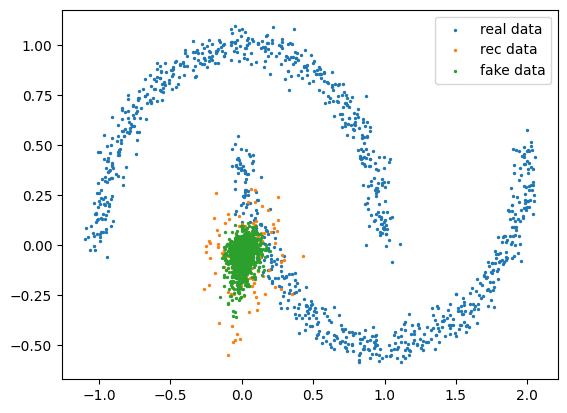

step 1000: KL: 2.842e+00, rec: -1.137e+00


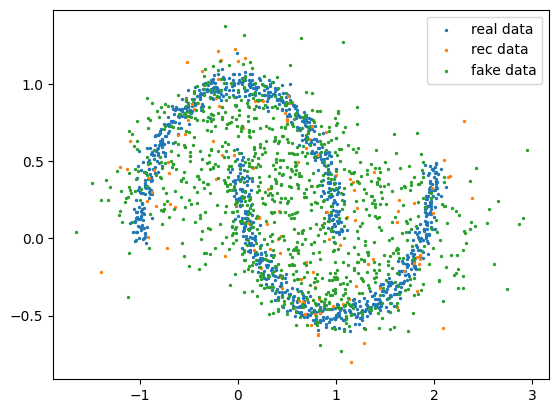

step 2000: KL: 2.780e+00, rec: -1.237e+00


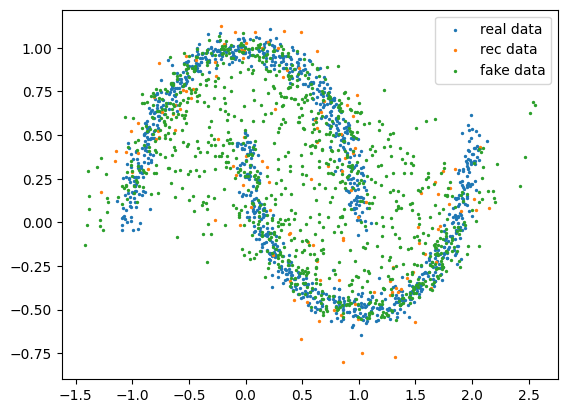

step 3000: KL: 2.708e+00, rec: -1.348e+00


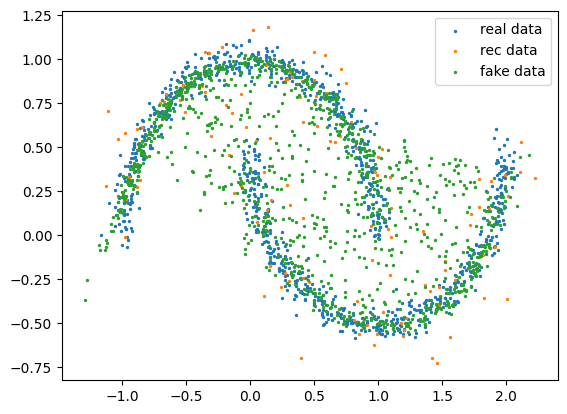

step 4000: KL: 2.703e+00, rec: -1.360e+00


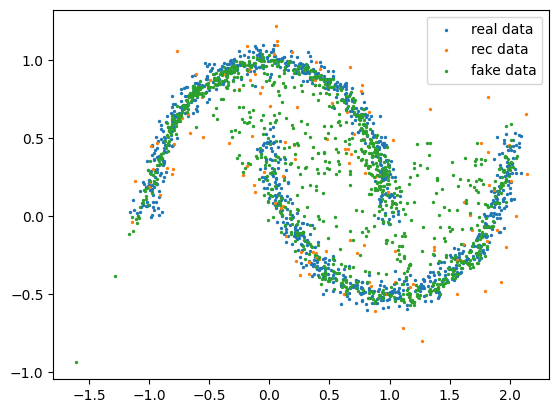

step 5000: KL: 2.693e+00, rec: -1.589e+00


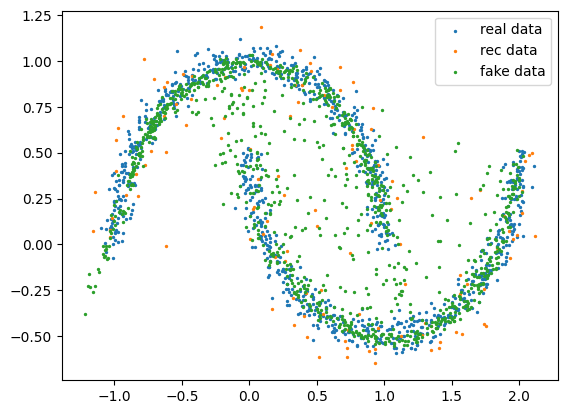

step 6000: KL: 2.699e+00, rec: -1.278e+00


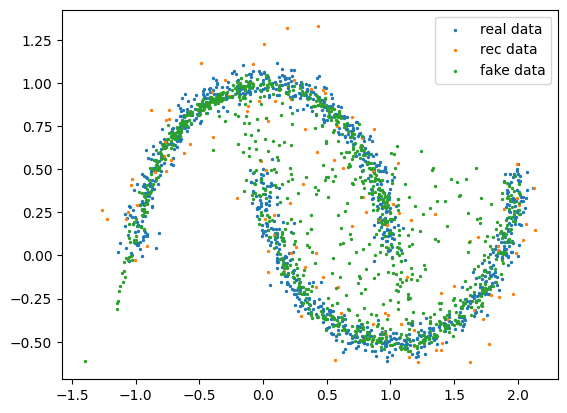

step 7000: KL: 2.734e+00, rec: -1.516e+00


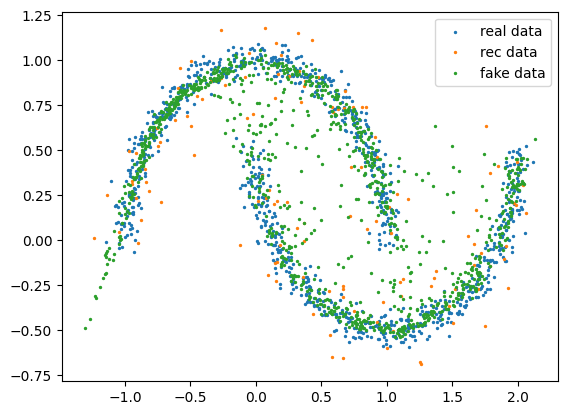

step 8000: KL: 2.691e+00, rec: -1.288e+00


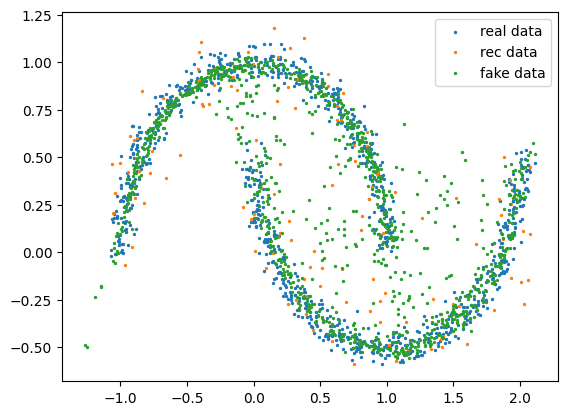

step 9000: KL: 2.657e+00, rec: -1.344e+00


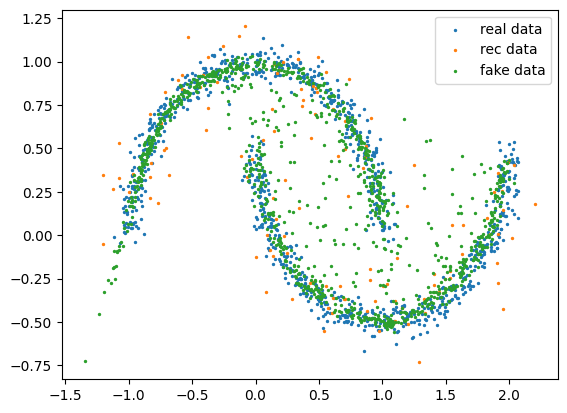

step 10000: KL: 2.673e+00, rec: -1.415e+00


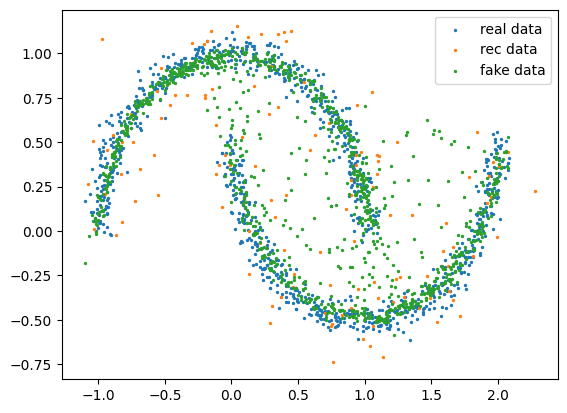

step 11000: KL: 2.658e+00, rec: -1.314e+00


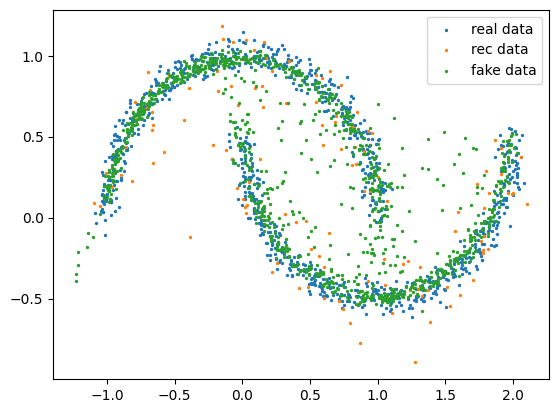

step 12000: KL: 2.696e+00, rec: -1.228e+00


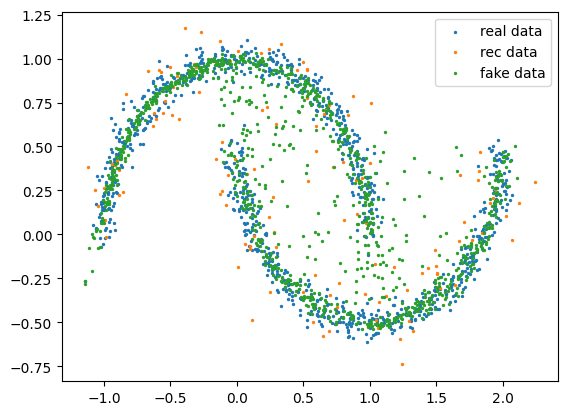

step 13000: KL: 2.645e+00, rec: -1.370e+00


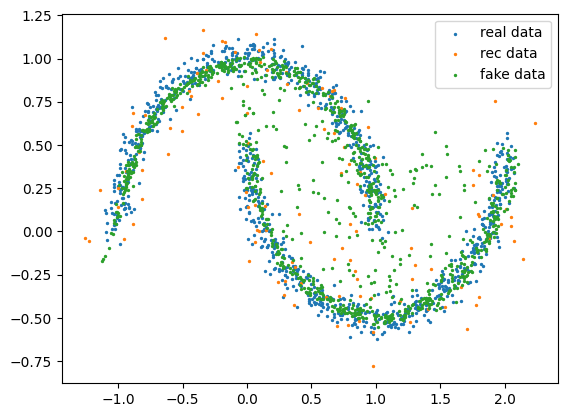

step 14000: KL: 2.717e+00, rec: -1.546e+00


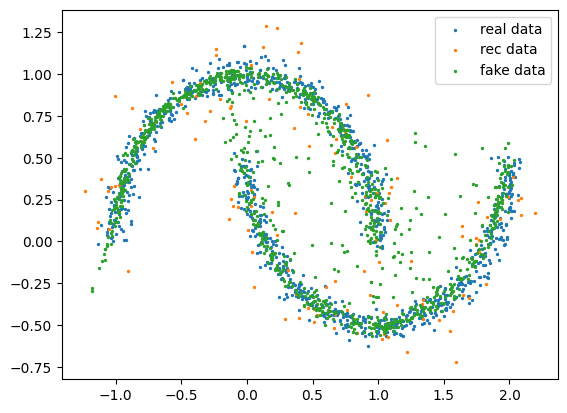

step 15000: KL: 2.664e+00, rec: -1.545e+00


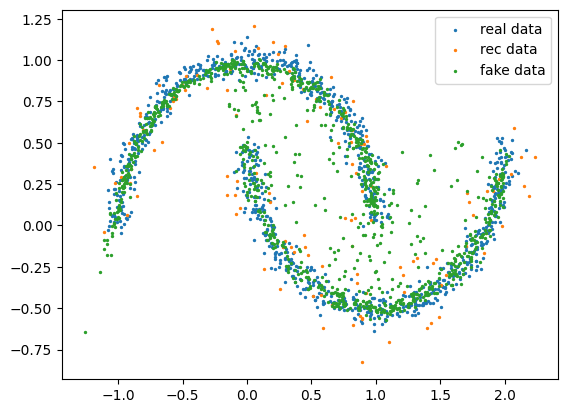

step 16000: KL: 2.688e+00, rec: -1.474e+00


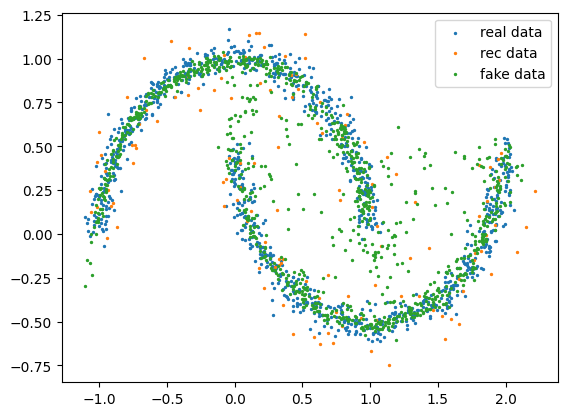

step 17000: KL: 2.674e+00, rec: -1.616e+00


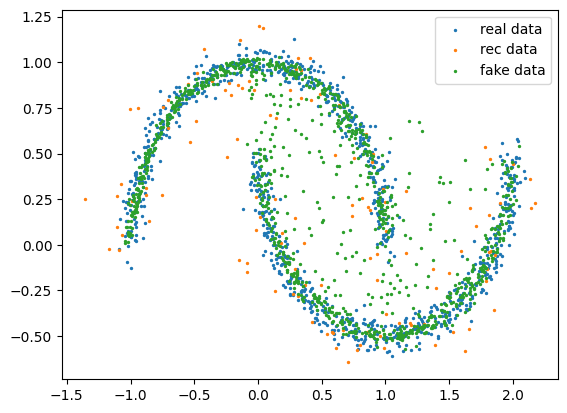

step 18000: KL: 2.657e+00, rec: -1.483e+00


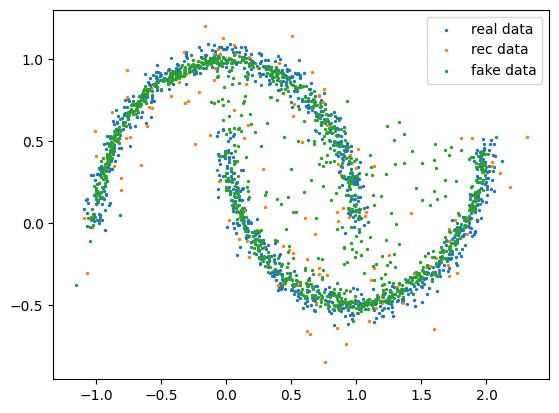

step 19000: KL: 2.671e+00, rec: -1.298e+00


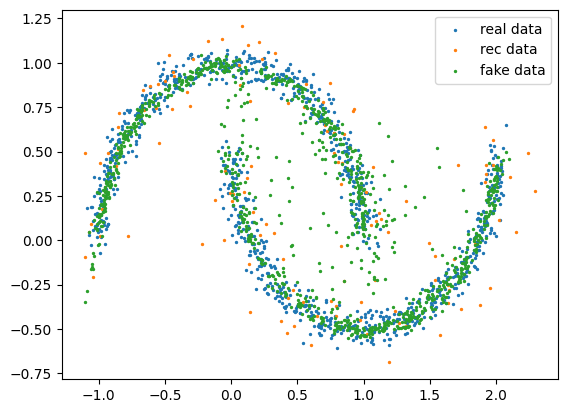

step 20000: KL: 2.730e+00, rec: -1.583e+00


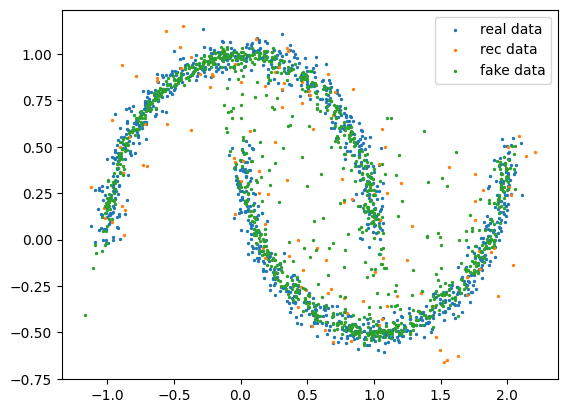

step 21000: KL: 2.670e+00, rec: -1.265e+00


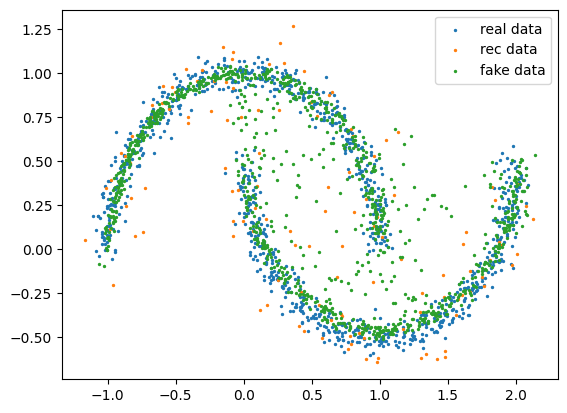

step 22000: KL: 2.685e+00, rec: -1.628e+00


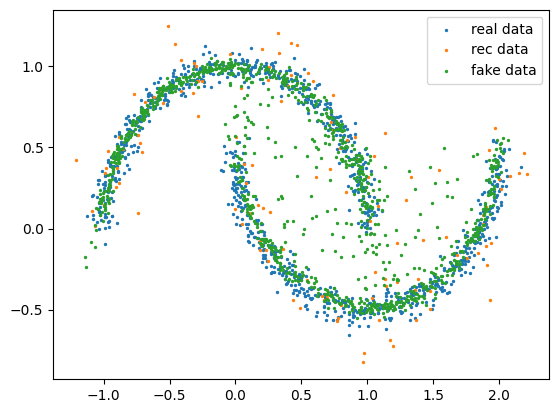

step 23000: KL: 2.643e+00, rec: -1.284e+00


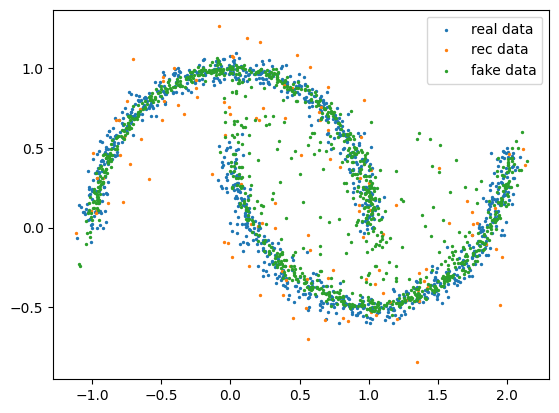

step 24000: KL: 2.684e+00, rec: -1.343e+00


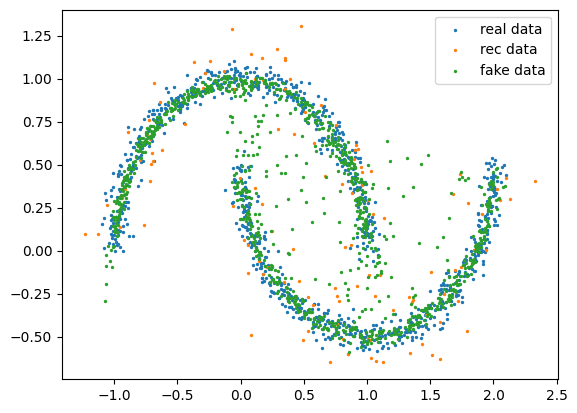

step 25000: KL: 2.663e+00, rec: -1.476e+00


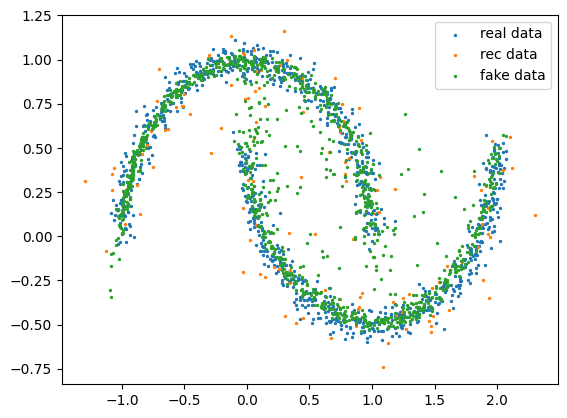

step 26000: KL: 2.743e+00, rec: -1.456e+00


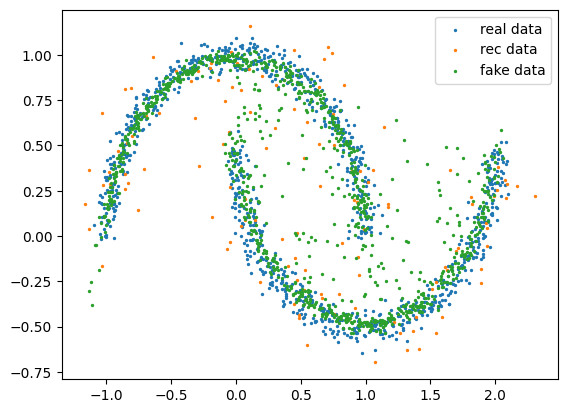

step 27000: KL: 2.672e+00, rec: -9.482e-01


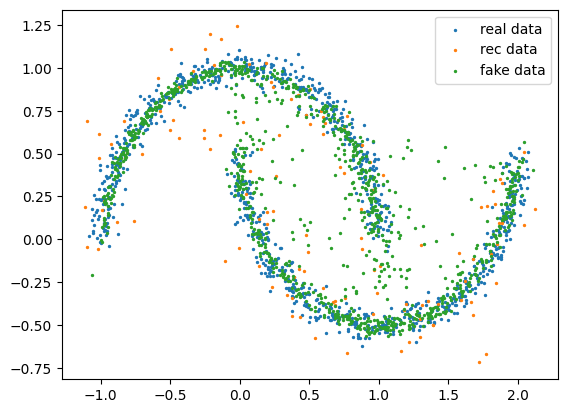

step 28000: KL: 2.739e+00, rec: -1.538e+00


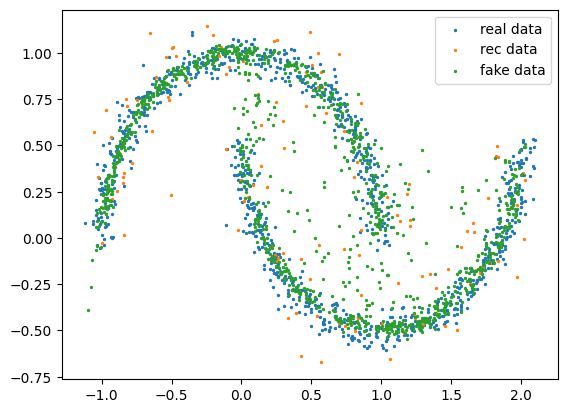

step 29000: KL: 2.769e+00, rec: -1.582e+00


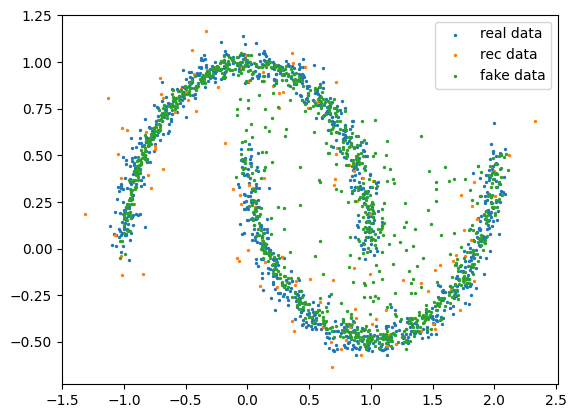

step 30000: KL: 2.673e+00, rec: -1.382e+00


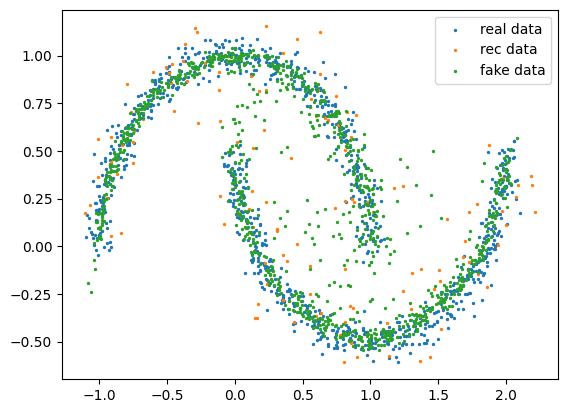

step 31000: KL: 2.756e+00, rec: -1.525e+00


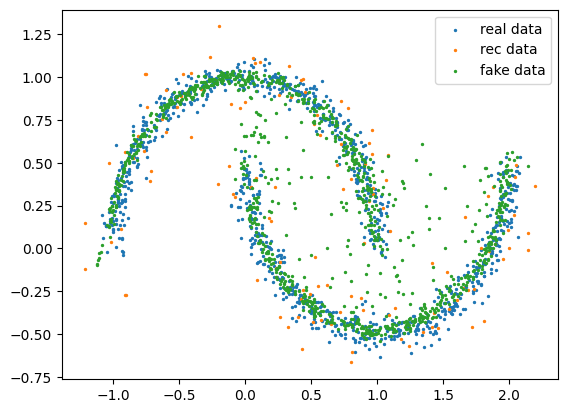

step 32000: KL: 2.661e+00, rec: -1.274e+00


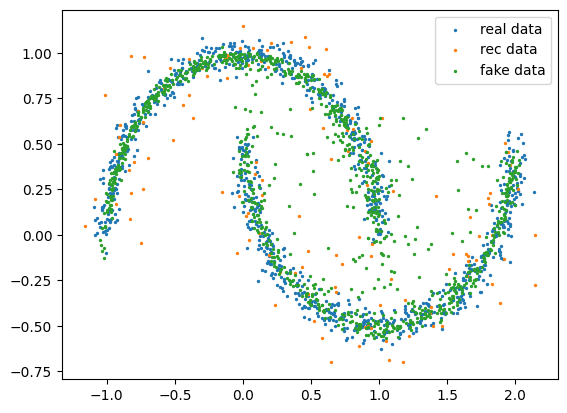

step 33000: KL: 2.690e+00, rec: -1.235e+00


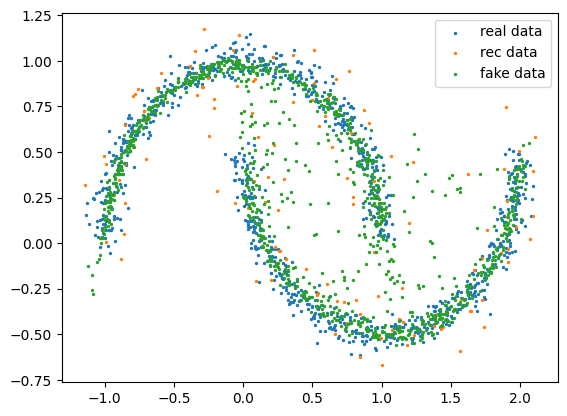

step 34000: KL: 2.716e+00, rec: -1.360e+00


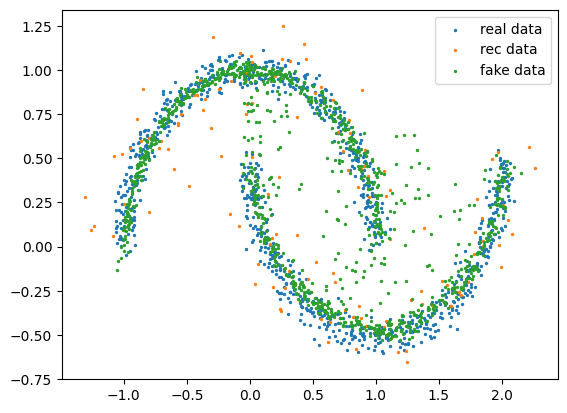

step 35000: KL: 2.631e+00, rec: -1.303e+00


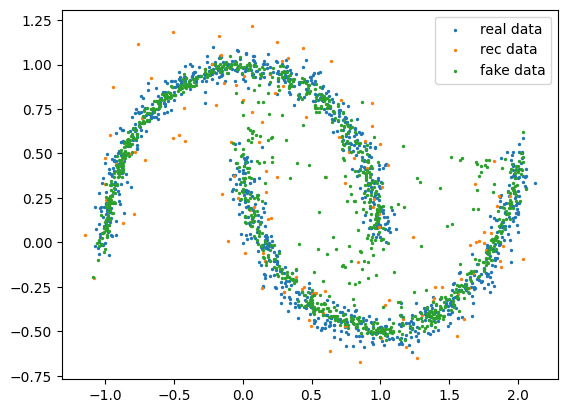

step 36000: KL: 2.755e+00, rec: -1.512e+00


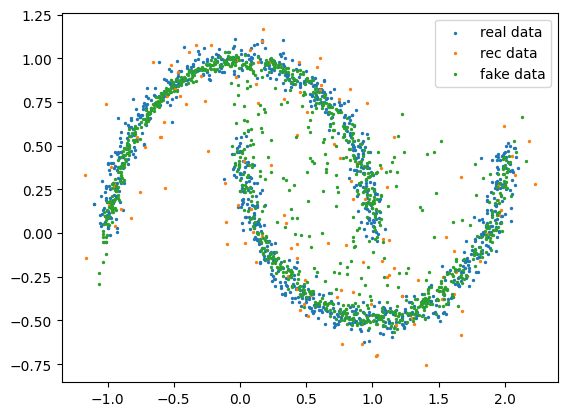

step 37000: KL: 2.673e+00, rec: -1.417e+00


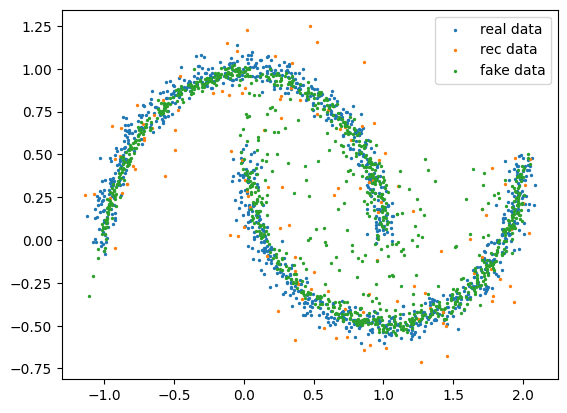

step 38000: KL: 2.696e+00, rec: -1.415e+00


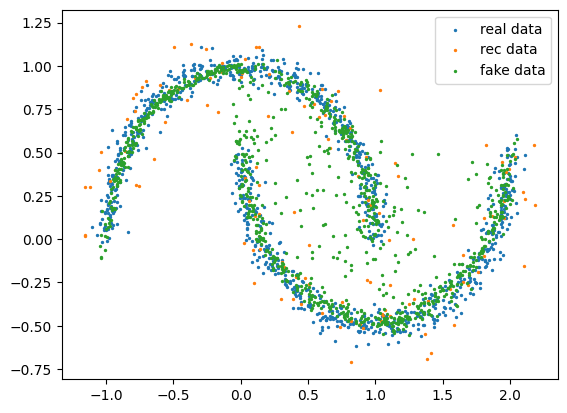

step 39000: KL: 2.690e+00, rec: -1.587e+00


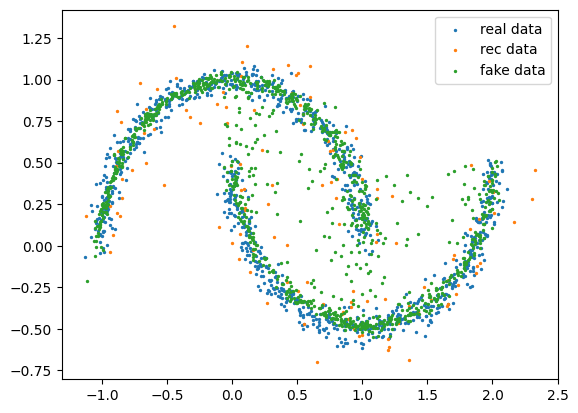

step 40000: KL: 2.611e+00, rec: -1.376e+00


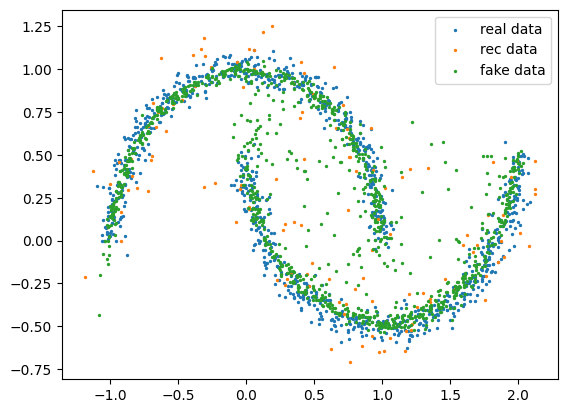

In [11]:
# Total number of training iterations for the VAE
N_ITER = 40001
# Batch size to use
BATCHLEN = 128

encoder = Encoder()
optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
decoder = Decoder()
optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()

    x = generate_batch(BATCHLEN)

    enc_mu, enc_logvar = encoder(x)
    #
    # COMPUTE THE KL PART OF THE LOSS HERE
    loss_kl = torch.mean(-0.5 * torch.sum(1 + enc_logvar - enc_mu ** 2 - enc_logvar.exp(), dim = 1), dim = 0)
    #
    #
    # SAMPLE z FROM q(z|x) HERE
    #
    enc_std = torch.exp(0.5 * enc_logvar)
    eps = torch.randn_like(enc_std)
    z = enc_mu + (eps * enc_std)

    q = torch.distributions.Normal(enc_mu, torch.exp(0.5 * enc_logvar))
    z = q.rsample()

    dec_mu, dec_logvar  = decoder(z)
    #
    # COMPUTE THE RECONSTRUCTION PART OF THE LOSS HERE
    #
    #dec_logvar = torch.ones(size=dec_logvar.shape) * 1e-4
    #p = torch.distributions.Normal(dec_mu, dec_logvar)

    p = torch.distributions.Normal(dec_mu, torch.exp(0.5 * dec_logvar))
    log_pxz = p.log_prob(x)
    loss_rec = - torch.mean(torch.sum(log_pxz, dim = 1), dim = 0)

    (loss_kl + loss_rec).backward()
    optim_enc.step()
    optim_dec.step()
    if i%1000 == 0:
        print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
        # plot the result
        real_batch = generate_batch(1024)
        rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
        fake_batch = decoder.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

**Q12: Try hardcoding $\sigma_\theta(z)$ to some small value (like 1E-4) rather than allowing the decoder to learn it. What does it change?**

> (Write your answer here, observe the plots)

**Q13: How do the power of encoder and decoder affect the overall training of the VAE?**

> (Write your answer here)

### Normalizing flows

Another approach to generative modelling is given by Normalizing flows. The idea is to learn a mapping $f$ from the data distribution $p_D$ (defined over a space $\mathcal{X}$) to a known distribution (typically, a normal distribution) from which we know how to sample. Two key points are to be noted:
1. The mapping needs to be bijective (i.e., the network needs to be invertible).
2. The exact likelihood of a data point should be easily computable.

To tackle point 2, let us introduce some notations.
Let us denote by $p_\mathcal{N} = \mathcal{N}(0,1)$ the normal distribution from which we sample $z$. We obtain points $x$ by computing $x = f^{-1}(z)$, and we hope that the distribution of points obtained this way will match more or less the dataset distribution $p_D$ of real examples.
We denote by $p_G$ this obtained distribution, that is, the image of $p_\mathcal{N}$ through $f^{-1}$: $p_G$ is a probability distribution defined on $\mathcal{X}$, and our goal will be to optimize the mapping $f$ so that $p_G$ is close to $p_D$. If you are not familiar with images of distributions, the definition is here: https://en.wikipedia.org/wiki/Pushforward_measure ; it can be defined as the measure that satisfies this change of variables: $\int_{z\sim p_\mathcal{N}} g(f^{-1}(z)) dz = \int_{x\sim p_{G}} g(x) dx$ for all functions $g$. Another notation for this is $\int_{z} g(f^{-1}(z)) \;dp_\mathcal{N}(z) = \int_{x} g(x) \;dp_{G}(x)$.
We will build on the following identity:
$$
\log(p_X(x))=\log(p_Z(z))+\log \det J_f
$$
where $J_f = \frac{df(x)}{dx}$ is the Jacobian matrix of the function $f$.

**Q14: Justify the above equality**

> we have $Z\sim p_\mathcal{Z}$ and $X=f^{-1}(Z)\sim p_X$.

Therefore: $$p_X(x)=p_Z(z))| \det \frac{dz}{dx}| = p_Z(z)| \det J_f|. $$

Which gives us :

$$
\log(p_X(x))=\log(p_Z(z))+\log(|\det J_f|)
$$



Let us consider, as an optimization criterion, the Kullback-Leibler divergence $KL(p_D||p_G)$.

**Q15: Express this loss as a (very simple) function of the quantity above.**

> $$D_{KL}(p_D \| p_G) = \mathbb{E}_{p_D}\left[ log(\frac{p_D}{p_G}) \right]$$

When X follows the disturbition $p_D$ and Z follows the disturbution $p_G$.

We get:

$$D_{KL}(p_D \| p_G) = \mathbb{E}_{p_D}\left[ log(\frac{p_D}{p_G}) \right]= \mathbb{E}_{p_D}\left[ log(p_D) -\log(p_G) \right] = \mathbb{E}_{p_D}\left[ \log(|\det J_f|) \right] = \log(|\det J_f|).$$

---
$$D_{KL}(p_D \| p_G) = \mathbb{E}_{p_D}\left[ log(\frac{p_D}{p_G}) \right]= \mathbb{E}_{p_D}\left[ log(p_D) -\log(p_G) \right] \\=
 \mathbb{E}_{p_D}\left[ log(p_D) - \log(p_N) - \log(det J_f) \right] = D_{KL}\left[ \log\frac{p_D}{p_N} \right] - \log(det J_f) $$

And minimizing this quantity is the same as minimizing

$$ - \mathbb{E}_{p_D}\left[ \log(p_G) \right] = - \mathbb{E}_{p_D}\left[ \log{p_N} \right] - \log(det J_f)$$

 ---

A challenging task is then to find a network, such that f is:
* invertible
* $\det J_f$ is tractable
* $f$ is general enough

A common architecture is the so called real-valued non-volume preserving (real-NVP), which is made of coupling layers.

The idea of coupling layers is to cut the input $x$ in two (let say keeping only the $d < D$ first dimensions on one hand and the $D-d$ other dimensions on the other hand, with $D$ the dimension of the input space $\mathcal{X}$). This gives inputs $x_{1:d}$ and $x_{d+1:D}$. Then the forward pass is defined as:
* $y_{1:d}=x_{1:d}$
* $y_{d+1:D}=x_{d+1:D}\odot \exp(s(x_{1:d})) + t(x_{1:d})$

where $s,t:\mathbb{R}^d\to\mathbb{R}^{D-d}$ and $\odot$ is the coefficient-wise multiplication of two vectors of the same size.

Those equations can be resumed in the following diagram:
![real NVP diagram](realNVPforward.png)

**Q16: Show that the defined mapping is indeed invertible**

> The mapping:
* $y_{1:d}=x_{1:d}$
* $y_{d+1:D}=x_{d+1:D}\odot \exp(s(x_{1:d})) + t(x_{1:d})$
is indeed invertible because:

* $y_{1:d}=x_{1:d}\iff x_{1:d} = y_{1:d}$


* $y_{d+1:D}=x_{d+1:D}\odot \exp(s(x_{1:d})) + t(x_{1:d})\iff x_{d+1:D} = (y_{d+1:D} - t(y_{1:d}))\odot \exp(-s(y_{1:d}).$

**Q17: Show that the determinant of the Jacobian of such a mapping is $\exp(\sum_j s(x_{1:d})_j)$**

> Let's find the Jacobian matrix:

it's easy to find that

$$J=\begin{bmatrix}
\mathbb{I}_d & \mathbb{O}_{d\times (d-D)}\\
\frac{\partial y_{d+1:D}}{\partial x_{1:d}} & diag(\exp(s(x_{1:d}))
\end{bmatrix}$$



\\


$$det J = \exp(\sum_j s(x_{1:d})_j).$$

**Q18: Fill the Coupling layer structure below by defining suitable functions sfun and tfun (using a final tanh in sfun is highly recommended) and the inverse pass**

In [12]:
import torch
from torch import nn
from torch.nn import functional as F


class CouplingLayer(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask):
        super().__init__()
        ### define here variables to use in f and s ###
        self.smodel = nn.Sequential(*[nn.Linear(input_size,hidden_size),nn.Tanh(),
                                        nn.Linear(hidden_size,output_size),nn.Tanh()])

        self.tmodel = nn.Sequential(*[nn.Linear(input_size,hidden_size),nn.Tanh(),
                                        nn.Linear(hidden_size,output_size),nn.Tanh()])

        ###
        self.mask = mask #we use the mask variable to make the cut in input

    def sfun(self, x_m):
        return self.smodel(x_m)

    def tfun(self, x_m):
        return self.tmodel(x_m)

    def forward(self, x):
        x_m = x * self.mask
        s_out = self.sfun(x_m) # multiplicative block
        t_out = self.tfun(x_m) # additive block
        y = x_m + (1-self.mask)*(x*torch.exp(s_out)+t_out)
        log_det_jacobian = s_out.sum(dim=1)  # CRITICAL
        return y, log_det_jacobian

    def inverse(self, y):
        x_m = y * (self.mask)
        s_out = self.sfun(x_m) # multiplicative block
        t_out = self.tfun(x_m) # additive block
        x_m2 = (y * (1-self.mask) - t_out)/torch.exp(s_out) * (1-self.mask)
        return x_m + x_m2

In [14]:
#Sanity check that inverse works well
mask = torch.from_numpy(np.array([0,1]))
l = CouplingLayer(2,2,64,mask)
x = torch.from_numpy(np.array([[1.5,2.]],np.float32))
y = l.forward(x)[0]
x2 = l.inverse(y)


In [15]:
x == x2

tensor([[False,  True]])

In [16]:
class RealNVP(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask, n_layers=6):
        super().__init__()
        assert n_layers >= 2, "num of coupling layers should be greater or equal to 2"

        self.modules = []
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        for _ in range(n_layers-2):
            mask = 1 - mask
            self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, 1 - mask))
        self.module_list = nn.ModuleList(self.modules)

    def forward(self, x):
        ldj_sum = 0  # sum of log determinant of jacobian
        for module in self.module_list:
            x, ldj = module(x)
            ldj_sum += ldj
        return x, ldj_sum

    def inverse(self, z):
        for module in reversed(self.module_list):
            z = module.inverse(z)
        return z

In [17]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch


def train(epoch, model, optimizer, prior_z, train_loader, log_interval=50):
    model.train()
    train_loss = 0
    for batch_idx, x_inputs in enumerate(train_loader):
        optimizer.zero_grad()
        z_outputs, log_det_j_sum = model.forward(x_inputs)  # train with the forward
        loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean()  # CRITICAL
        loss.backward()
        cur_loss = loss.item()
        train_loss += cur_loss
        optimizer.step()
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(x_inputs), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), cur_loss / len(x_inputs)))

    average_train_loss = train_loss / len(train_loader.dataset)
    print(f"====> Epoch: {epoch} Average train loss: {average_train_loss:.4f}")


def test(epoch, model, prior_z, test_loader):
    model.eval()
    test_loss = 0
    x_all = np.array([[]]).reshape(0, 2)
    z_all = np.array([[]]).reshape(0, 2)
    with torch.no_grad():
        for batch_idx, x_inputs in enumerate(test_loader):
            z_outputs, log_det_j_sum = model.forward(x_inputs)
            cur_loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean().item()
            test_loss += cur_loss
            x_all = np.concatenate((x_all, x_inputs.numpy()))
            z_all = np.concatenate((z_all, z_outputs.numpy()))

        subfig_plot(1, x_all, -2, 3, -1, 1.5, "Input: x ~ p(x)", "b")
        subfig_plot(2, z_all, -3, 3, -3, 3, "Output: z = f(x)", "b")

        test_loss /= len(test_loader.dataset)
        print(f"====> Test loss: {test_loss:.4f}")


def sample(epoch, model, prior_z, save_plt_interval=5):
    model.eval()
    with torch.no_grad():
        z_inputs = prior_z.sample((1000,))
        x_outputs = model.inverse(z_inputs)  # generation with the inverse
        z_inputs = z_inputs.numpy()
        x_outputs = x_outputs.numpy()

        subfig_plot(3, z_inputs, -3, 3, -3, 3, "Input: z ~ p(z)", "r")
        subfig_plot(4, x_outputs, -2, 3, -1, 1.5, "Output: x = g(z) (g: inverse of f)", "r")

        if epoch % save_plt_interval == 0:
            if not os.path.exists("results"):
                os.makedirs("results")
            plt.savefig("results/"+"result_"+str(epoch)+".png")


def subfig_plot(location, data, x_start, x_end, y_start, y_end, title, color):
    if location == 1:
        plt.clf()
    plt.subplot(2, 2, location)
    plt.scatter(data[:, 0], data[:, 1], c=color, s=1)
    plt.xlim(x_start, x_end)
    plt.ylim(y_start, y_end)
    plt.title(title)
    plt.pause(1e-2)

In [18]:
# globals
BATCH_SIZE = 128
LOG_INTERVAL = 50
N_EPOCHS = 10
INPUT_SIZE = 2
OUTPUT_SIZE = 2
HIDDEN_SIZE = 256
SAVE_PLT_INTERVAL = 5
N_COUPLING_LAYERS = 8

In [19]:
# data loading
train_data = datasets.make_moons(n_samples=50000, noise=.05)[0].astype(np.float32)
test_data = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loader_kwargs = {"num_workers": 1, "pin_memory": True} if device == "cuda" else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)

In [20]:
from torch import distributions # optim,
# model construction
mask = torch.from_numpy(np.array([0, 1]).astype(np.float32))
model = RealNVP(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_SIZE, mask, N_COUPLING_LAYERS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
prior_z = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

Train Epoch: 1 [0/50000 (0%)]	Loss: 0.021716
Train Epoch: 1 [6400/50000 (13%)]	Loss: -0.013596
Train Epoch: 1 [12800/50000 (26%)]	Loss: -0.028861
Train Epoch: 1 [19200/50000 (38%)]	Loss: -0.038123
Train Epoch: 1 [25600/50000 (51%)]	Loss: -0.041114
Train Epoch: 1 [32000/50000 (64%)]	Loss: -0.043972
Train Epoch: 1 [38400/50000 (77%)]	Loss: -0.045271
Train Epoch: 1 [44800/50000 (90%)]	Loss: -0.046850
====> Epoch: 1 Average train loss: -0.0340


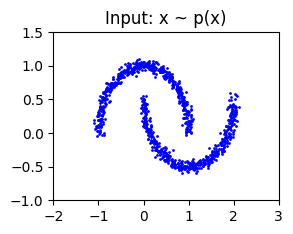

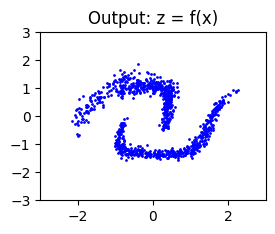

====> Test loss: -0.0487


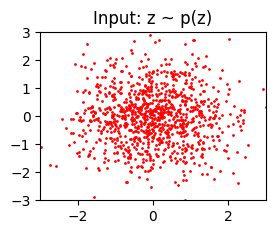

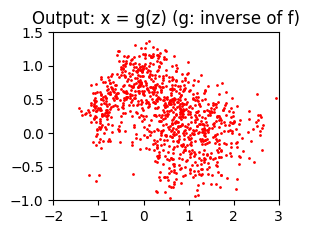

Train Epoch: 2 [0/50000 (0%)]	Loss: -0.047581
Train Epoch: 2 [6400/50000 (13%)]	Loss: -0.049108
Train Epoch: 2 [12800/50000 (26%)]	Loss: -0.048549
Train Epoch: 2 [19200/50000 (38%)]	Loss: -0.049871
Train Epoch: 2 [25600/50000 (51%)]	Loss: -0.050764
Train Epoch: 2 [32000/50000 (64%)]	Loss: -0.050537
Train Epoch: 2 [38400/50000 (77%)]	Loss: -0.051179
Train Epoch: 2 [44800/50000 (90%)]	Loss: -0.051080
====> Epoch: 2 Average train loss: -0.0500


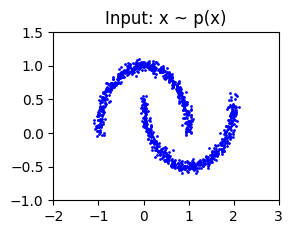

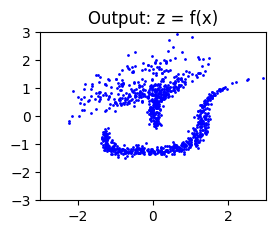

====> Test loss: -0.0524


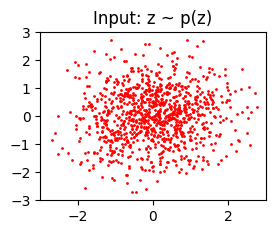

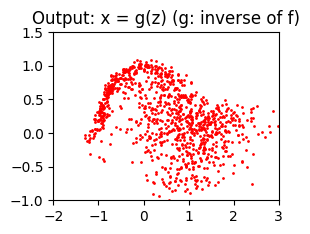

Train Epoch: 3 [0/50000 (0%)]	Loss: -0.051267
Train Epoch: 3 [6400/50000 (13%)]	Loss: -0.050987
Train Epoch: 3 [12800/50000 (26%)]	Loss: -0.051401
Train Epoch: 3 [19200/50000 (38%)]	Loss: -0.052888
Train Epoch: 3 [25600/50000 (51%)]	Loss: -0.051796
Train Epoch: 3 [32000/50000 (64%)]	Loss: -0.052714
Train Epoch: 3 [38400/50000 (77%)]	Loss: -0.051774
Train Epoch: 3 [44800/50000 (90%)]	Loss: -0.052925
====> Epoch: 3 Average train loss: -0.0518


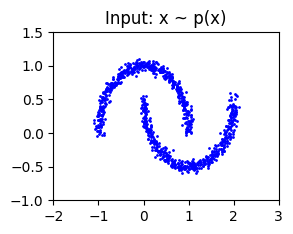

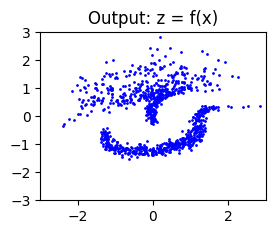

====> Test loss: -0.0536


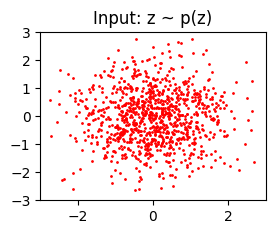

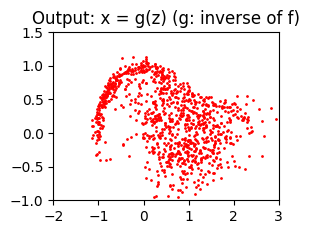

Train Epoch: 4 [0/50000 (0%)]	Loss: -0.051891
Train Epoch: 4 [6400/50000 (13%)]	Loss: -0.052646
Train Epoch: 4 [12800/50000 (26%)]	Loss: -0.052264
Train Epoch: 4 [19200/50000 (38%)]	Loss: -0.052800
Train Epoch: 4 [25600/50000 (51%)]	Loss: -0.052764
Train Epoch: 4 [32000/50000 (64%)]	Loss: -0.053131
Train Epoch: 4 [38400/50000 (77%)]	Loss: -0.053645
Train Epoch: 4 [44800/50000 (90%)]	Loss: -0.054111
====> Epoch: 4 Average train loss: -0.0529


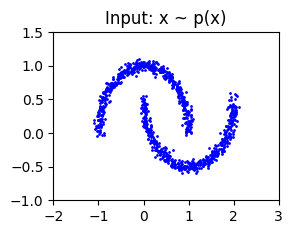

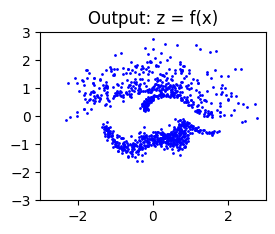

====> Test loss: -0.0548


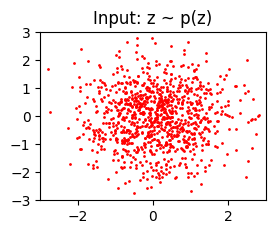

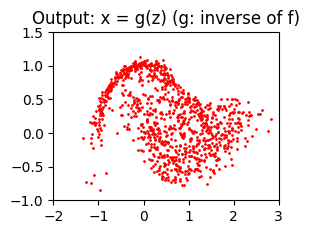

Train Epoch: 5 [0/50000 (0%)]	Loss: -0.054034
Train Epoch: 5 [6400/50000 (13%)]	Loss: -0.053547
Train Epoch: 5 [12800/50000 (26%)]	Loss: -0.052966
Train Epoch: 5 [19200/50000 (38%)]	Loss: -0.053062
Train Epoch: 5 [25600/50000 (51%)]	Loss: -0.053719
Train Epoch: 5 [32000/50000 (64%)]	Loss: -0.053978
Train Epoch: 5 [38400/50000 (77%)]	Loss: -0.053224
Train Epoch: 5 [44800/50000 (90%)]	Loss: -0.052161
====> Epoch: 5 Average train loss: -0.0538


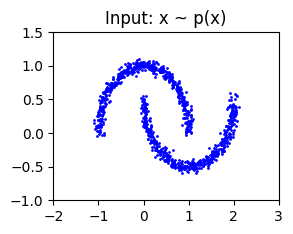

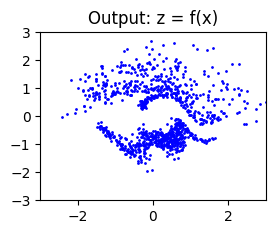

====> Test loss: -0.0555


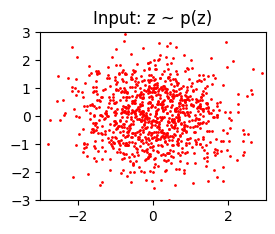

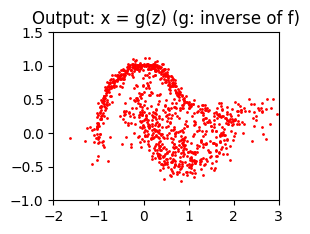

Train Epoch: 6 [0/50000 (0%)]	Loss: -0.053418
Train Epoch: 6 [6400/50000 (13%)]	Loss: -0.053988
Train Epoch: 6 [12800/50000 (26%)]	Loss: -0.053456
Train Epoch: 6 [19200/50000 (38%)]	Loss: -0.054942
Train Epoch: 6 [25600/50000 (51%)]	Loss: -0.053272
Train Epoch: 6 [32000/50000 (64%)]	Loss: -0.054218
Train Epoch: 6 [38400/50000 (77%)]	Loss: -0.054582
Train Epoch: 6 [44800/50000 (90%)]	Loss: -0.054691
====> Epoch: 6 Average train loss: -0.0542


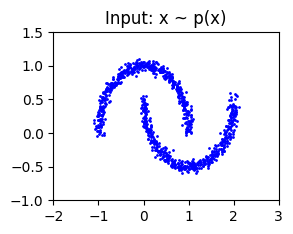

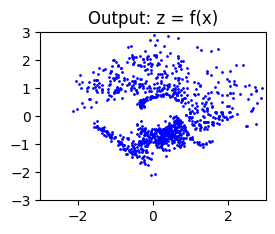

====> Test loss: -0.0556


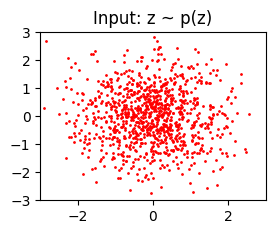

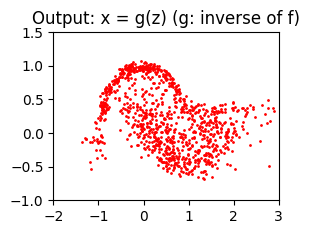

Train Epoch: 7 [0/50000 (0%)]	Loss: -0.054816
Train Epoch: 7 [6400/50000 (13%)]	Loss: -0.054974
Train Epoch: 7 [12800/50000 (26%)]	Loss: -0.054760
Train Epoch: 7 [19200/50000 (38%)]	Loss: -0.054345
Train Epoch: 7 [25600/50000 (51%)]	Loss: -0.054473
Train Epoch: 7 [32000/50000 (64%)]	Loss: -0.054625
Train Epoch: 7 [38400/50000 (77%)]	Loss: -0.054906
Train Epoch: 7 [44800/50000 (90%)]	Loss: -0.054840
====> Epoch: 7 Average train loss: -0.0545


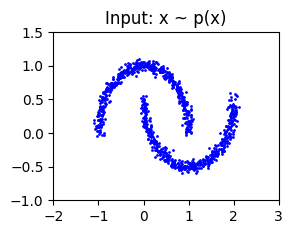

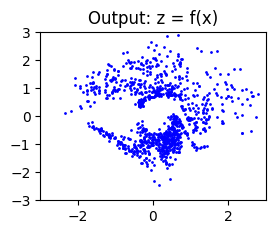

====> Test loss: -0.0559


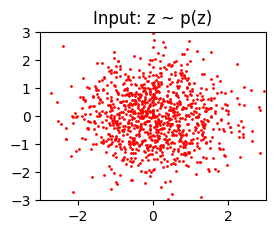

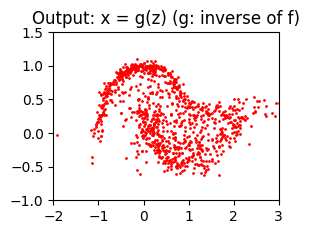

Train Epoch: 8 [0/50000 (0%)]	Loss: -0.052943
Train Epoch: 8 [6400/50000 (13%)]	Loss: -0.054314
Train Epoch: 8 [12800/50000 (26%)]	Loss: -0.055442
Train Epoch: 8 [19200/50000 (38%)]	Loss: -0.054508
Train Epoch: 8 [25600/50000 (51%)]	Loss: -0.054969
Train Epoch: 8 [32000/50000 (64%)]	Loss: -0.054840
Train Epoch: 8 [38400/50000 (77%)]	Loss: -0.055318
Train Epoch: 8 [44800/50000 (90%)]	Loss: -0.054695
====> Epoch: 8 Average train loss: -0.0548


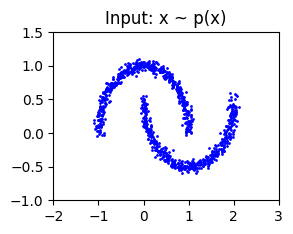

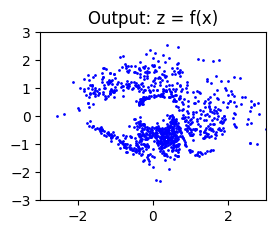

====> Test loss: -0.0561


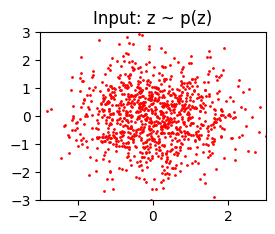

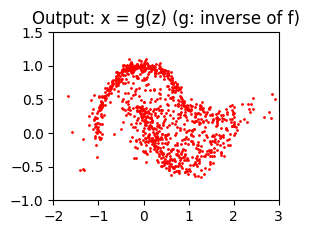

Train Epoch: 9 [0/50000 (0%)]	Loss: -0.055177
Train Epoch: 9 [6400/50000 (13%)]	Loss: -0.054825
Train Epoch: 9 [12800/50000 (26%)]	Loss: -0.054467
Train Epoch: 9 [19200/50000 (38%)]	Loss: -0.055347
Train Epoch: 9 [25600/50000 (51%)]	Loss: -0.055630
Train Epoch: 9 [32000/50000 (64%)]	Loss: -0.054409
Train Epoch: 9 [38400/50000 (77%)]	Loss: -0.054063
Train Epoch: 9 [44800/50000 (90%)]	Loss: -0.054054
====> Epoch: 9 Average train loss: -0.0550


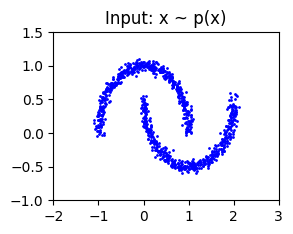

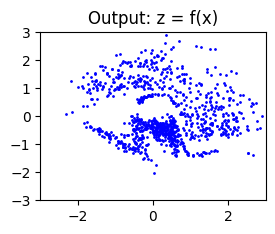

====> Test loss: -0.0560


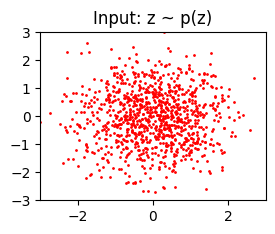

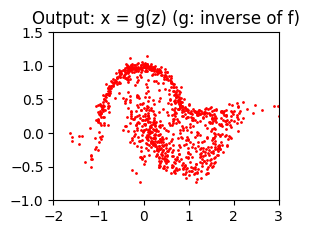

Train Epoch: 10 [0/50000 (0%)]	Loss: -0.055342
Train Epoch: 10 [6400/50000 (13%)]	Loss: -0.054904
Train Epoch: 10 [12800/50000 (26%)]	Loss: -0.054739
Train Epoch: 10 [19200/50000 (38%)]	Loss: -0.054810
Train Epoch: 10 [25600/50000 (51%)]	Loss: -0.055084
Train Epoch: 10 [32000/50000 (64%)]	Loss: -0.055126
Train Epoch: 10 [38400/50000 (77%)]	Loss: -0.054658
Train Epoch: 10 [44800/50000 (90%)]	Loss: -0.054723
====> Epoch: 10 Average train loss: -0.0550


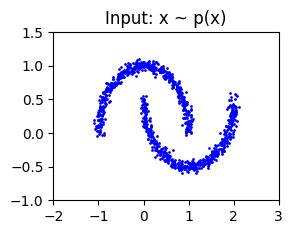

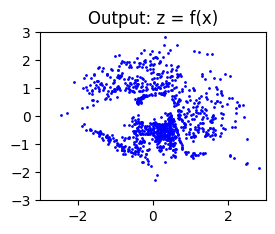

====> Test loss: -0.0566


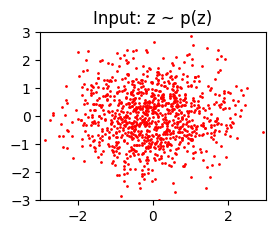

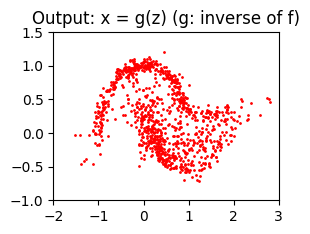

'65.28s'

<Figure size 640x480 with 0 Axes>

In [21]:
from timeit import default_timer as timer
# run
start = timer()
for epoch in range(1, N_EPOCHS + 1):
    train(epoch, model, optimizer, prior_z, train_loader)
    test(epoch, model, prior_z, test_loader)
    sample(epoch, model, prior_z)
f"{timer() - start:.02f}s"

**Q19: Explain why Normalizing flows do not fit well when there are many clusters in data**

> In order to do the clustering task, Normalizing flows estimate a probability density in a high-dimensional space from only a handful of observations which gives a poor density estimation ( espically in the case of a high number of clusters). Therefore, The testing observations will not be any near the training observations which will cause an inaccurate probability density in each cluster. Hence Normalizing flows do not fit well when there are many clusters in data.


**Q20: As a conclusion, how would you compare the advantages and shortcomings of GANs, VAEs and Normalizing flows?**

###GANS:
* Advantages:


1.   They generate data that looks similar to original data.

2.   They perform well even with limited data. **(not sure : limited data -> discriminator overfits -> generator overfits on the train set and doesn't generalize - it will learn a sum of dirac corresponding to the train set)**
3.   The latent space has lesser dimensions which makes it iterpretable.


* Shortcomings:



1.   Harder to train:  They need to be updated with diverse data to keep their perfomance in check.
2.   Slow Convergence: the model has time and space complexity than other models like CNN, RNN.



### VAEs:
* Advantages:

1. Capable of learning smooth latent state representations of the input data.
2. Great results.
* Shortcomings:

1.   They injected noise in the generated the generated samples  which make them are much more blurred and less accurate than those coming from GANs.
2.   Minimizing $D_{KL}$, Tend to assign high probability to points in data
set but also to other points which are blurry.




### Normalizing flows:
* Advantages:


1.   Since they do not need to put noise on the output, they are more powerful local variance models.
2. Normalizing flows converge much more easily when compared to GANs and VAEs.


* Shortcoming:


1.   The samples that are generated are not as good when compared to GANs and VAEs (issue with many different components).
2. Flow models need to be bijective whichleads to a very high dimensional latent space that's hard to interpret and expressive networks might be hard to design due to the constraints of the function f.

